In [27]:
# pip install numpy matplotlib pandas scikit-learn geopandas scipy anndata

# Preliminaries

## Import library

In [28]:
import epsbasin
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.tri import Triangulation
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import geopandas as gpd
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
import anndata
from collections import OrderedDict
from matplotlib.lines import Line2D
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## File path

In [29]:
DATA_DIR = "data"
DATA_NAME = "Typhoon/Tracks.2020-12.DOLPHIN.csv"
OUTPUT_DIR = "Figure_source"

## Read input data

In [30]:
df_input = pd.read_csv(f"{DATA_DIR}/{DATA_NAME}", header=0, sep=";", skiprows=0)
df_input

InitializationTime         ForecastTime  Horizon  Member         type  \
0     2020-09-20 12:00:00  2020-09-20 12:00:00        0       0  Unperturbed   
1     2020-09-20 12:00:00  2020-09-20 15:00:00        3       0  Unperturbed   
2     2020-09-20 12:00:00  2020-09-20 18:00:00        6       0  Unperturbed   
3     2020-09-20 12:00:00  2020-09-20 21:00:00        9       0  Unperturbed   
4     2020-09-20 12:00:00  2020-09-21 00:00:00       12       0  Unperturbed   
...                   ...                  ...      ...     ...          ...   
6463  2020-09-25 18:00:00  2020-09-26 21:00:00       27      20    Perturbed   
6464  2020-09-25 18:00:00  2020-09-27 00:00:00       30      20    Perturbed   
6465  2020-09-25 18:00:00  2020-09-27 03:00:00       33      20    Perturbed   
6466  2020-09-25 18:00:00  2020-09-27 06:00:00       36      20    Perturbed   
6467  2020-09-25 18:00:00  2020-09-27 09:00:00       39      20    Perturbed   

         lon    lat             X             Y          prmsl         X1  \
0     134.02  24.04  4.003495e+05  2.659003e+06  100583.734375   0.000000   
1     133.75  24.62  3.734719e+05  2.723442e+06  100442.109375  -0.308428   
2     133.46  24.72  3.442297e+05  2.734824e+06  100236.843750  -0.643991   
3     133.56  24.67  3.542884e+05  2.729174e+06  100252.906250  -0.528565   
4     133.71  24.80  3.696176e+05  2.743412e+06  100248.265625  -0.352657   
...      ...    ...           ...           ...            ...        ...   
6463  147.03  43.55  1.472091e+06  4.892749e+06  100120.859375  15.593206   
6464  147.65  44.19  1.511152e+06  4.971422e+06  100155.468750  16.161530   
6465  146.81  45.45  1.423357e+06  5.101242e+06   99995.492188  14.884157   
6466  146.87  46.04  1.418180e+06  5.167432e+06   99812.023438  14.808828   
6467  147.07  46.49  1.425927e+06  5.219744e+06   99719.125000  14.921552   

             Y1        Xs        Ys                               id1  \
0      0.000000 -1.338151 -1.672546  20200920120000_20200920133000_00   
1      0.515353 -1.404047 -1.567601  20200920120000_20200920163000_00   
2      0.606384 -1.475740 -1.549063  20200920120000_20200920193000_00   
3      0.561196 -1.451079 -1.558265  20200920120000_20200920223000_00   
4      0.675066 -1.413496 -1.535077  20200920120000_20200921013000_00   
...         ...       ...       ...                               ...   
6463  12.480294  1.289449  1.965347  20200925180000_20200926223000_20   
6464  12.919853  1.385216  2.093474  20200925180000_20200927013000_20   
6465  13.645179  1.169969  2.304900  20200925180000_20200927043000_20   
6466  14.014991  1.157275  2.412697  20200925180000_20200927073000_20   
6467  14.307267  1.176270  2.497893  20200925180000_20200927103000_20   

           id2  
0     01_01_00  
1     01_02_00  
2     01_03_00  
3     01_04_00  
4     01_05_00  
...        ...  
6463  22_10_20  
6464  22_11_20  
6465  22_12_20  
6466  22_13_20  
6467  22_14_20  

[6468 rows x 16 columns]

In [31]:
print("Start InitializationTime\t%s" % df_input["InitializationTime"].loc[0])
print("End InitializationTime\t%s" % df_input["InitializationTime"].values[-1])
print("#InitializationTime\t%d" % len(np.unique(df_input["InitializationTime"].values)))
print("#ForecastTime\t%d" % len(np.unique(df_input["ForecastTime"].values)))
print("#Ensemble\t%d" % len(np.unique(df_input["Member"].values)))

Start InitializationTime	2020-09-20 12:00:00
End InitializationTime	2020-09-25 18:00:00
#InitializationTime	22
#ForecastTime	56
#Ensemble	21


## Construct anndata

In [32]:
adata = anndata.AnnData(
    df_input[['lon', 'lat']].values,
    obs=df_input,
    uns={'cost_matrix': pairwise_distances(df_input[['lon', 'lat']].values)}
)
adata

AnnData object with n_obs × n_vars = 6468 × 2
    obs: 'InitializationTime', 'ForecastTime', 'Horizon', 'Member', 'type', 'lon', 'lat', 'X', 'Y', 'prmsl', 'X1', 'Y1', 'Xs', 'Ys', 'id1', 'id2'
    uns: 'cost_matrix'

## Set index of sequence

In [33]:
df_input_tmp = df_input.set_index(['InitializationTime', 'Member'])
adata.obs['seq_id'] = pd.factorize(df_input_tmp.index)[0]

## Read best track data

In [34]:
best_track_df = pd.read_csv(f"{DATA_DIR}/Typhoon/Best.Track.2020-12.DOLPHIN.csv", header=0, sep=",")

## Read background geographic data

In [35]:
background = gpd.read_file(f"{DATA_DIR}/geopandas/ne_110m_admin_0_countries.shp")

## Set ensamble colors

In [36]:
ensamble_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
            '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5',
            '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f',
            '#e5c494', '#b3b3b3', '#1f78b4', '#33a02c', '#fb9a99', '#cab2d6']

## Visualization of Input Data

In [37]:
def plot_ensemble_by_init_time(
    adata, long_lim=None, lati_lim=None, background=None, colors=None, show_legend=True,
    show_xlabel=True, show_ylabel=True,
    show_xticklabels=True, show_yticklabels=True,figsize=(10, 10),
    save_fig=False, save_fig_dir="outputs", save_fig_prefix="Dolphin_ensemble_"
):
    """
    Plot ensemble tracks for each InitializationTime in adata.obs.

    Parameters
    ----------
    adata : AnnData
        AnnData object with .obs containing 'InitializationTime', 'Member', 'lon', 'lat'.
    long_lim : list or None, optional
        Longitude limits for the plot [min, max].
    lati_lim : list or None, optional
        Latitude limits for the plot [min, max].
    background : GeoDataFrame or None, optional
        GeoDataFrame for background map (e.g., world boundaries).
    colors : list or None, optional
        List of color codes for plotting different members.
    show_legend : bool, default True
        Whether to display the legend.
    show_xlabel : bool, default True
        Whether to display the x-axis label.
    show_ylabel : bool, default True
        Whether to display the y-axis label.
    show_xticklabels : bool, default True
        Whether to display x-axis tick labels.
    show_yticklabels : bool, default True
        Whether to display y-axis tick labels.
    save_fig : bool, default False
        Whether to save the figure.
    save_fig_dir : str, default "outputs"
        Directory to save the figure.
    save_fig_prefix : str, default "Dolphin_ensemble_"
        Prefix for the saved figure filename.
    figsize : tuple, default (10, 10)
        Figure size for the plot.

    Returns
    -------
    None
    """
    if colors is None:
        colors = plt.get_cmap('tab20').colors

    unique_init_times = adata.obs['InitializationTime'].unique()
    for init_time in unique_init_times:
        group = adata.obs[adata.obs['InitializationTime'] == init_time]
        fig, ax = plt.subplots(figsize=figsize)
        if background is not None:
            background.plot(ax=ax, color='lightgray', zorder=0)
        plt.scatter(adata.obs['lon'], adata.obs['lat'], color='lightgray', s=3, alpha=0.8, label='All Points', zorder=20)
        for i, member in enumerate(group['Member'].unique()):
            member_group = group[group['Member'] == member].sort_index()
            ax.plot(member_group['lon'], member_group['lat'], marker='o', markersize=5, label=f'Member {member}', zorder=30, color=colors[i % len(colors)])
        ax.text(
            0.02, 0.98, init_time[:-3],
            ha='left', va='top', fontsize=24,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
        )
        if long_lim is not None:
            ax.set_xlim(long_lim)
        if lati_lim is not None:
            ax.set_ylim(lati_lim)
        if show_xlabel:
            ax.set_xlabel('Longitude')
        if show_ylabel:
            ax.set_ylabel('Latitude')
        ax.grid(ls="--", zorder=10)
        if not show_xticklabels:
            ax.set_xticklabels([])
        if not show_yticklabels:
            ax.set_yticklabels([])
        if show_legend:
            ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=14)
        if save_fig:
            os.makedirs(save_fig_dir, exist_ok=True)
            init_time_modified = init_time.replace(' ', '_').split(':')[0]
            plt.savefig(f"{save_fig_dir}/{save_fig_prefix}{init_time_modified}.png", bbox_inches="tight")
        plt.show()

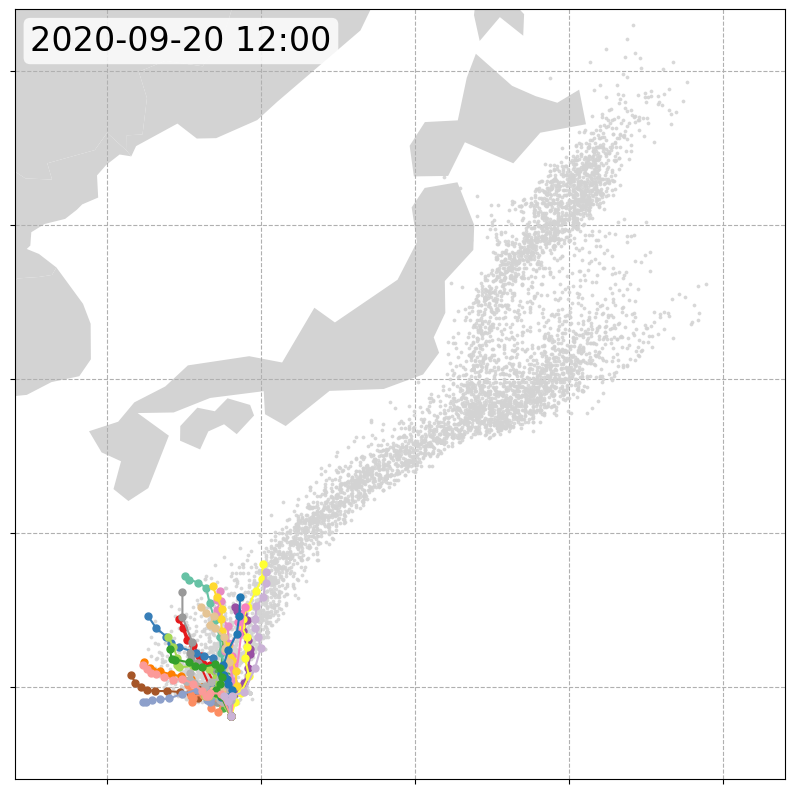

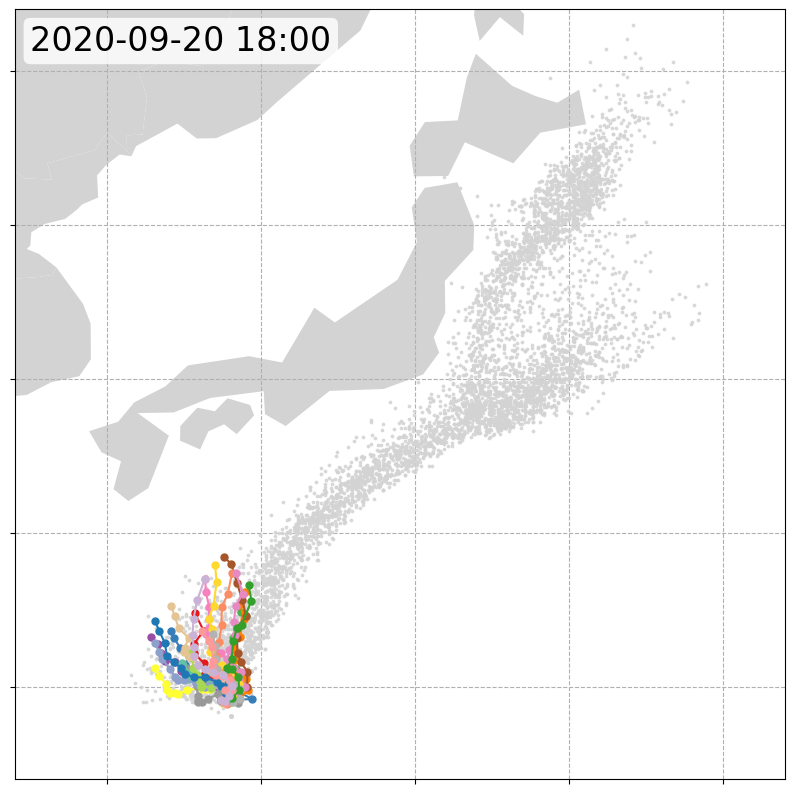

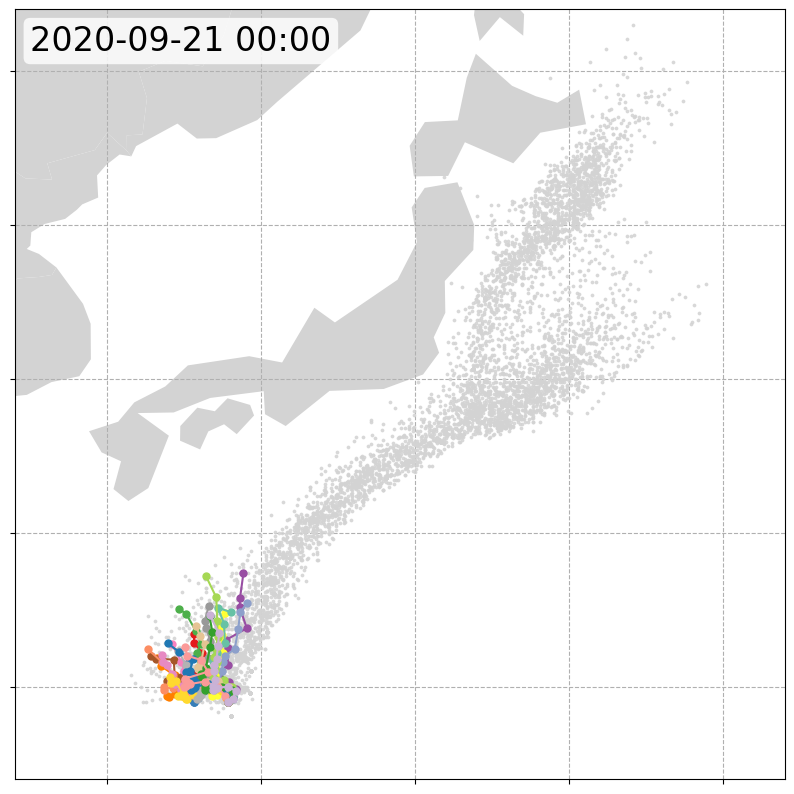

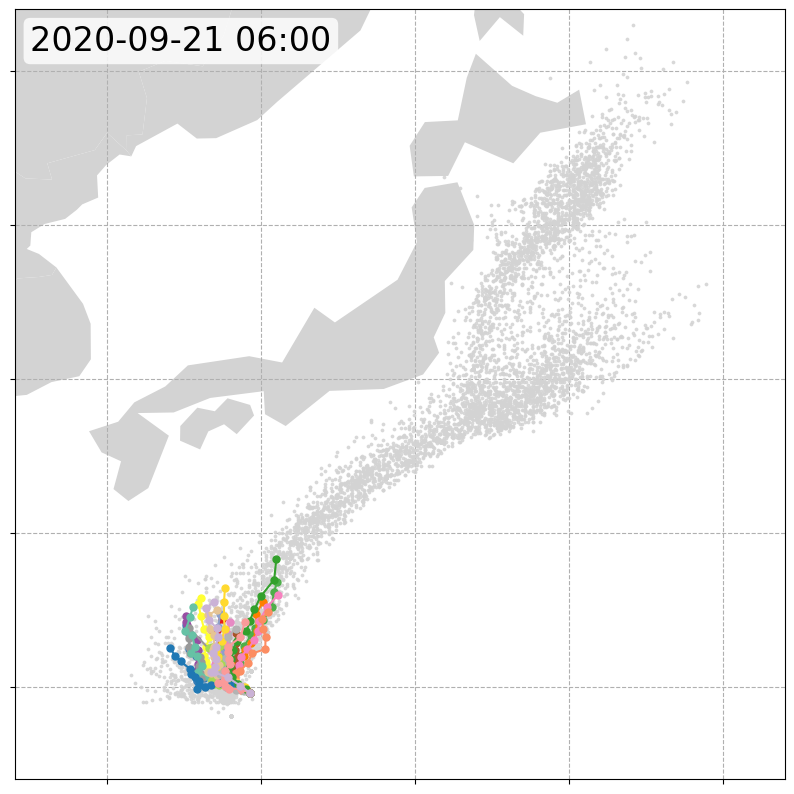

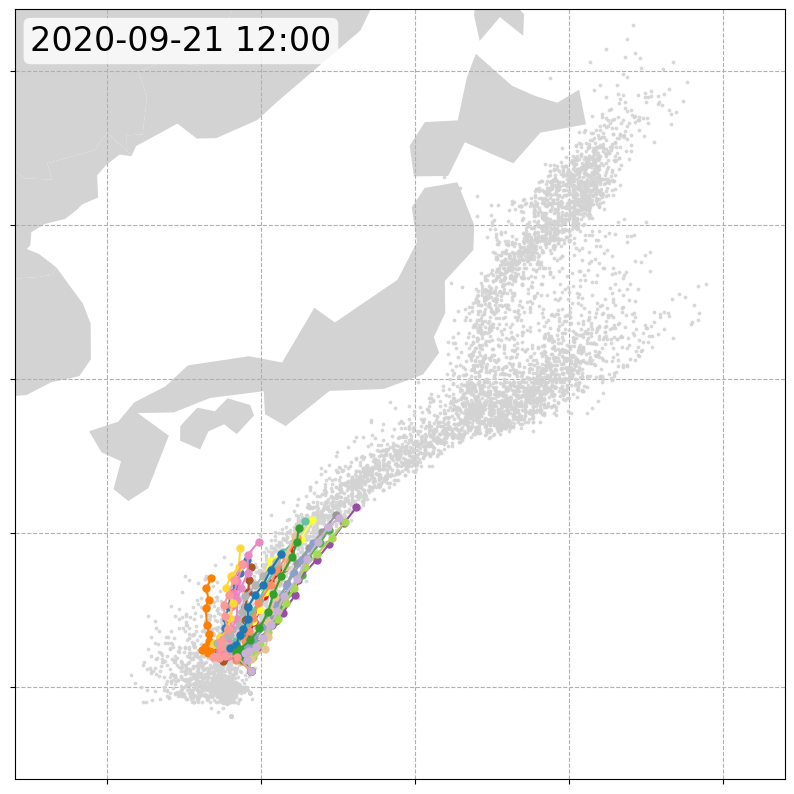

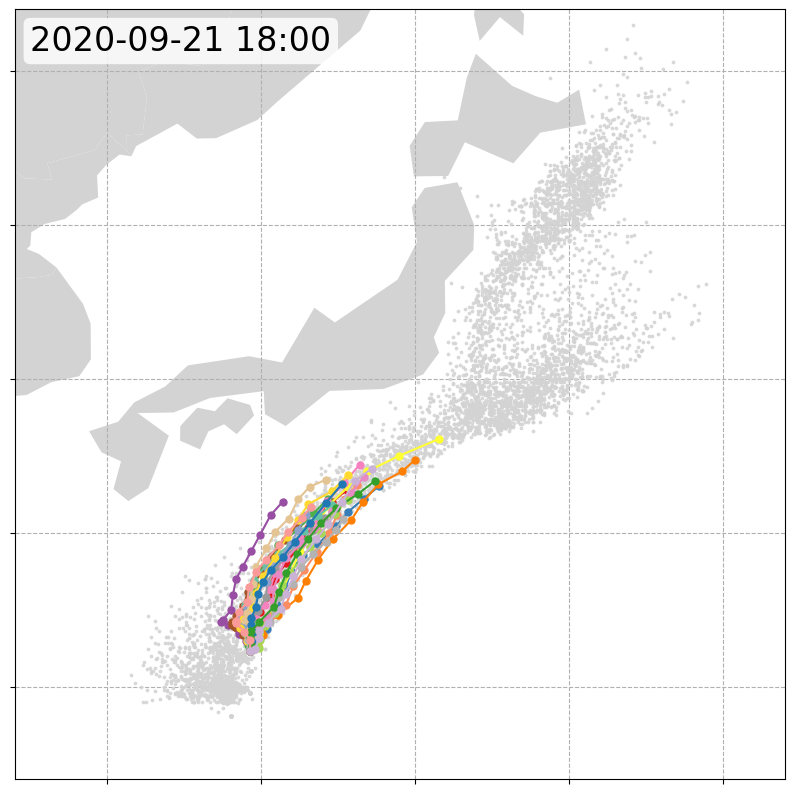

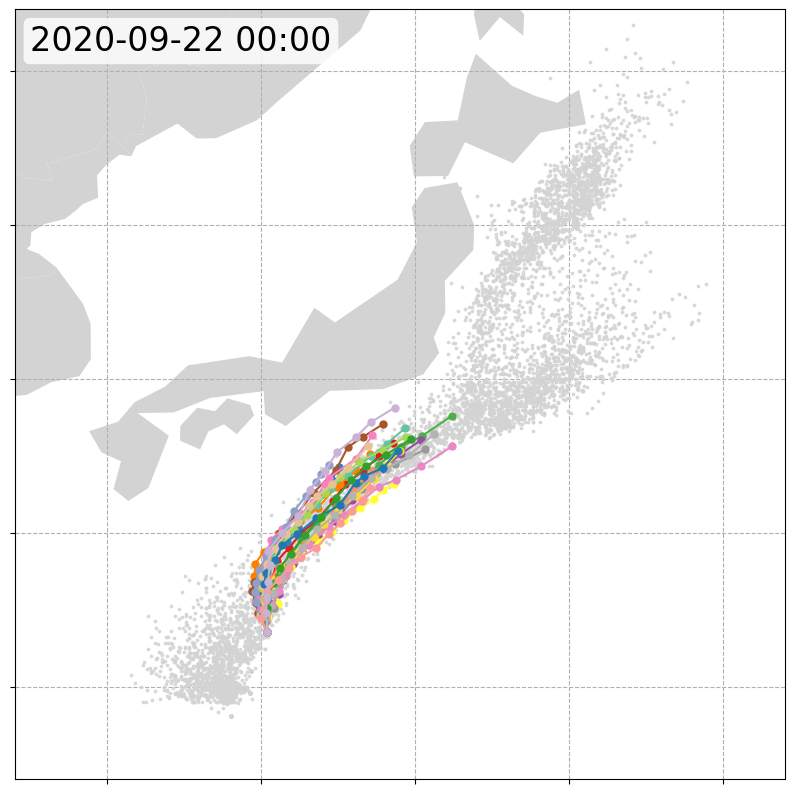

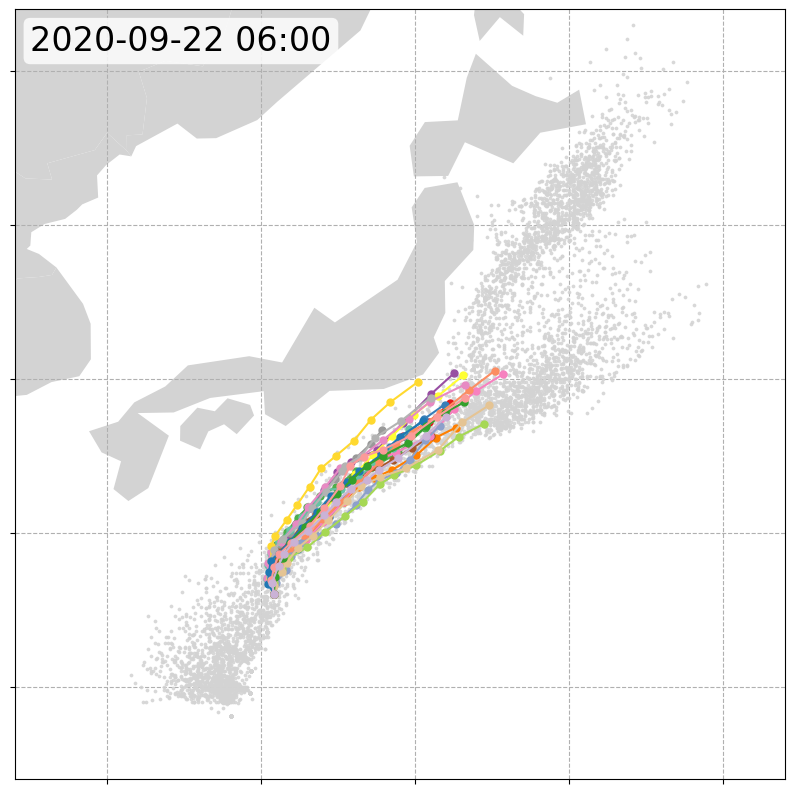

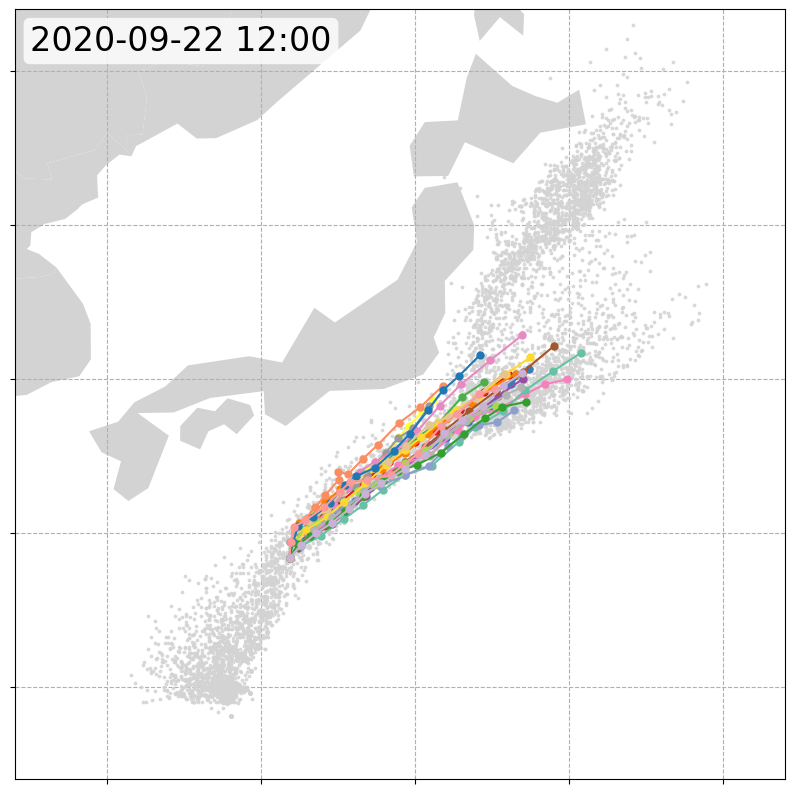

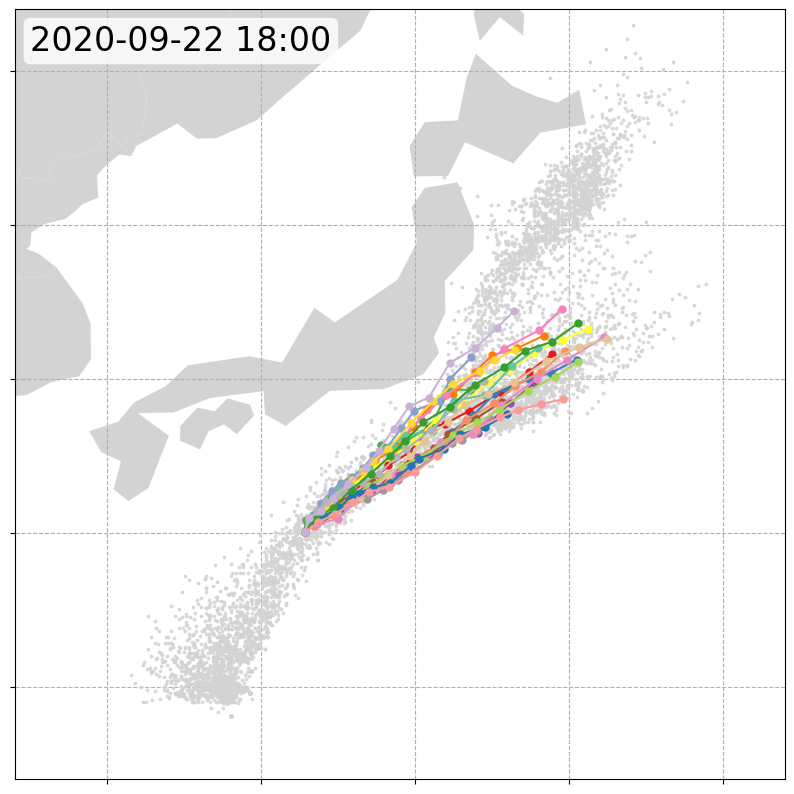

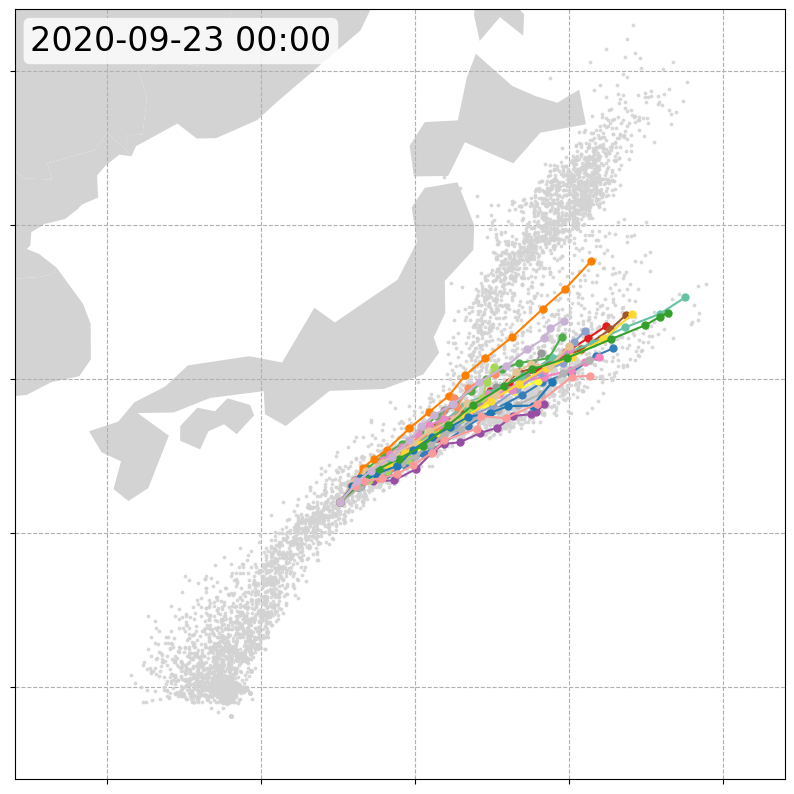

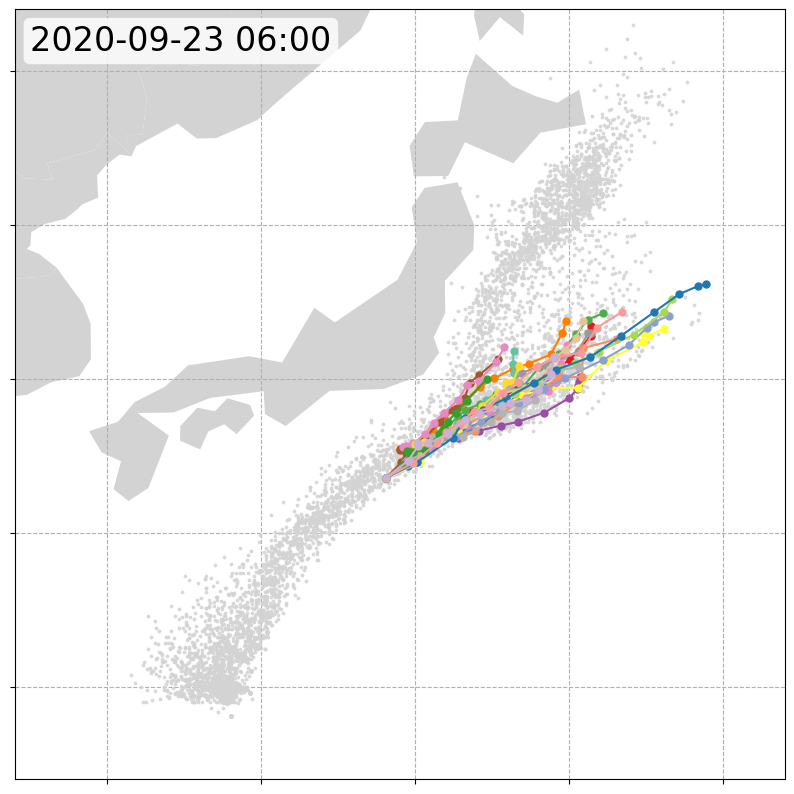

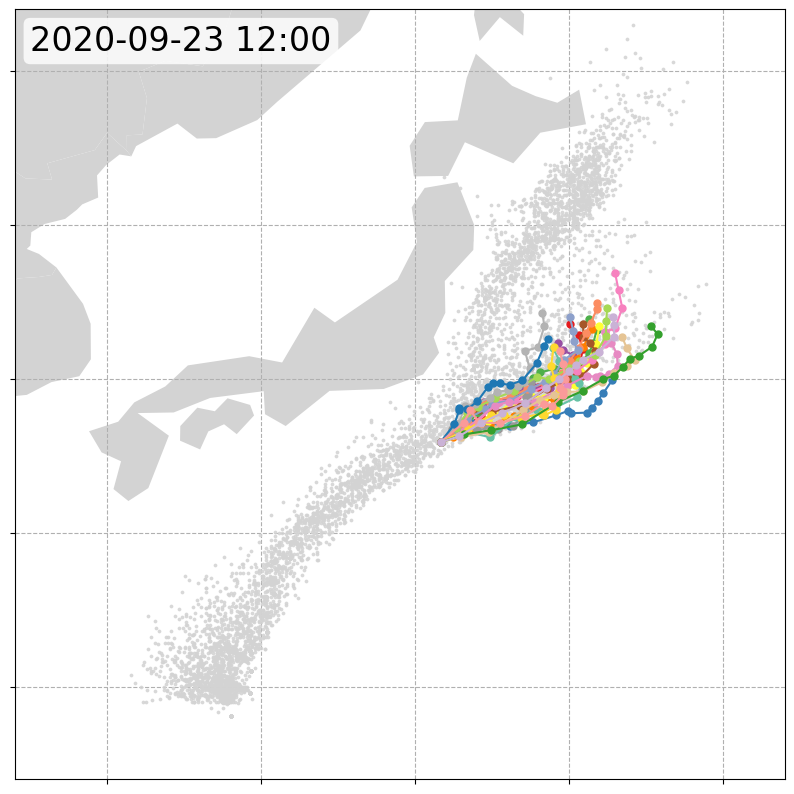

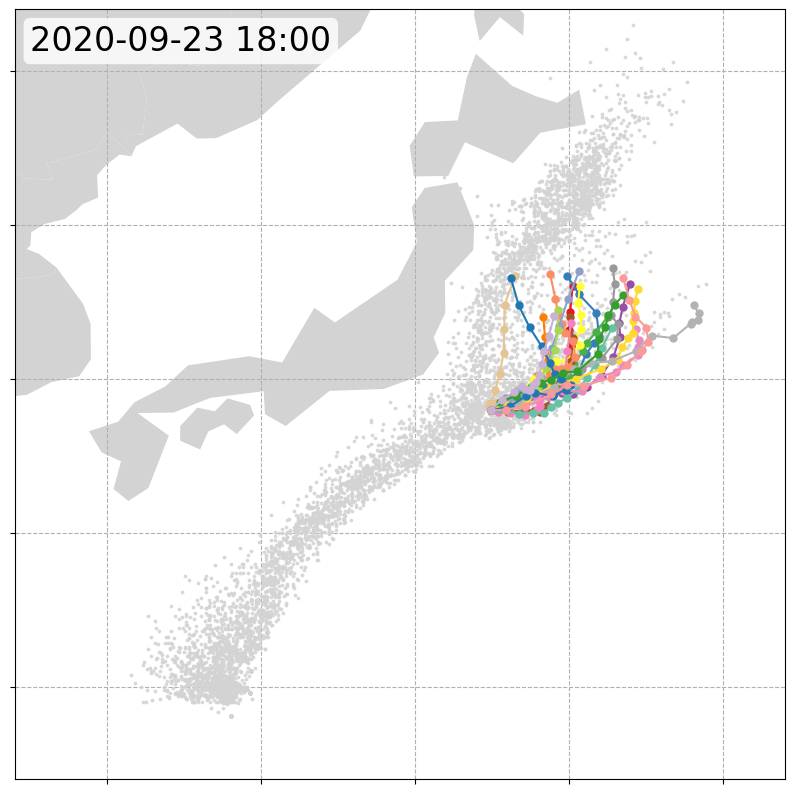

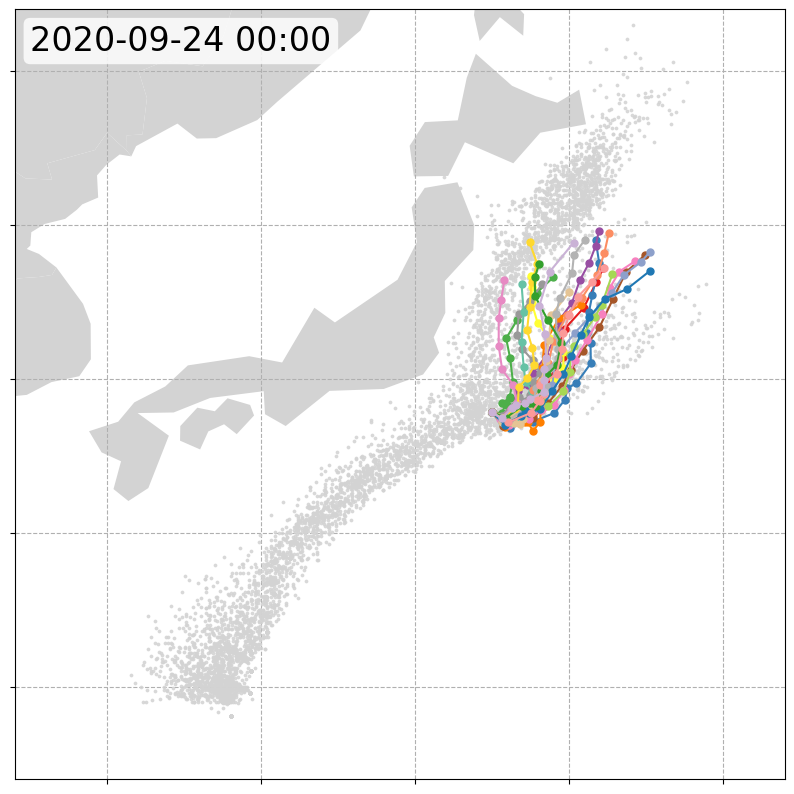

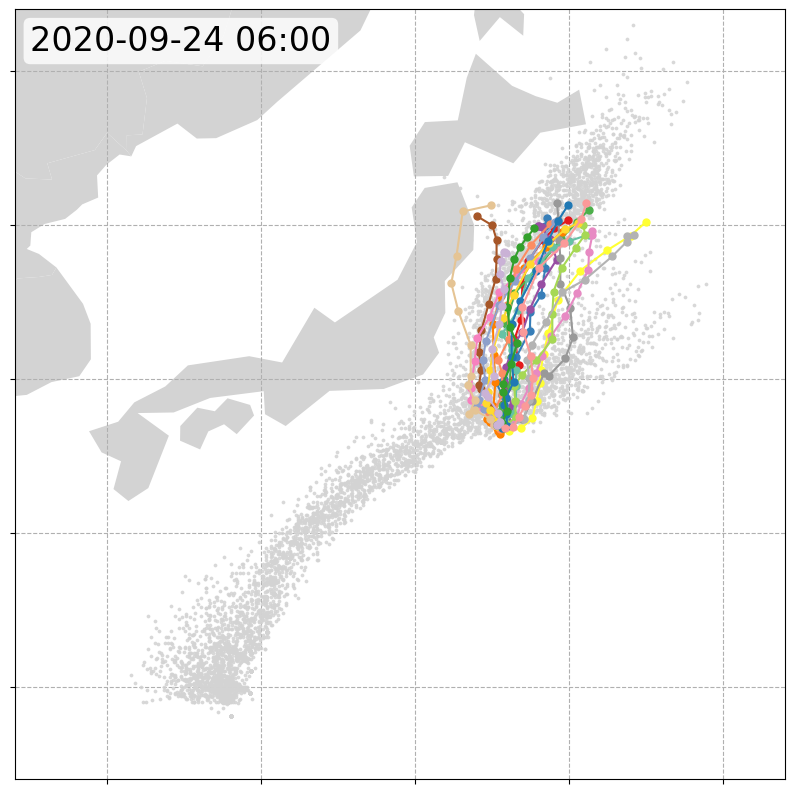

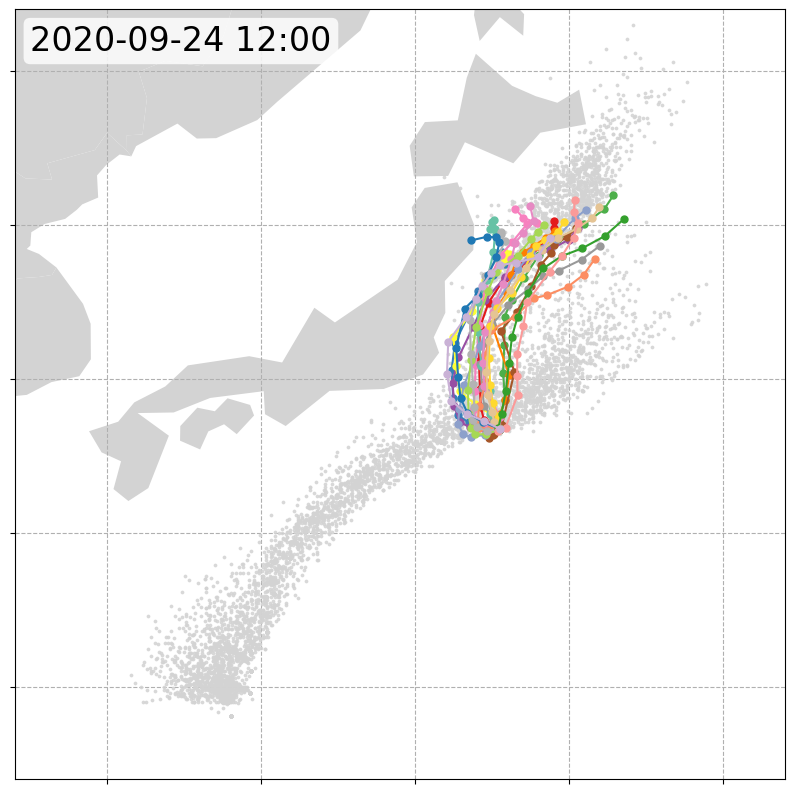

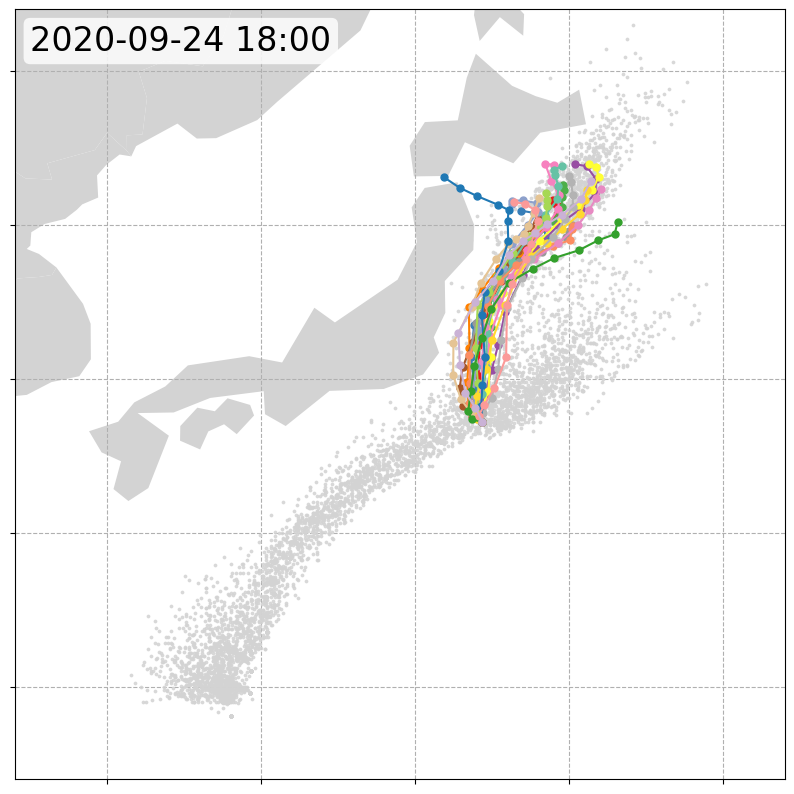

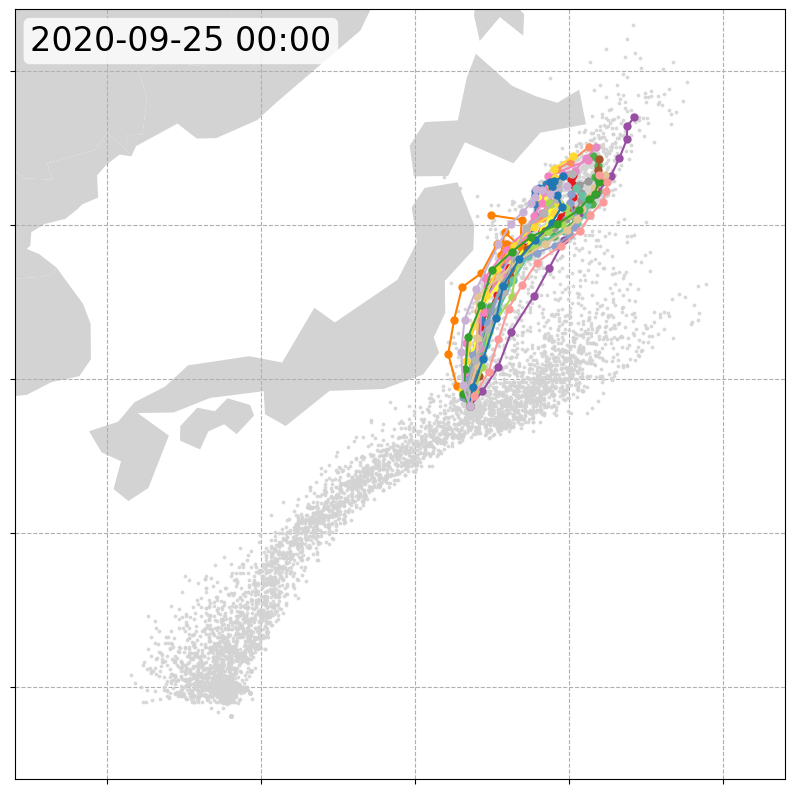

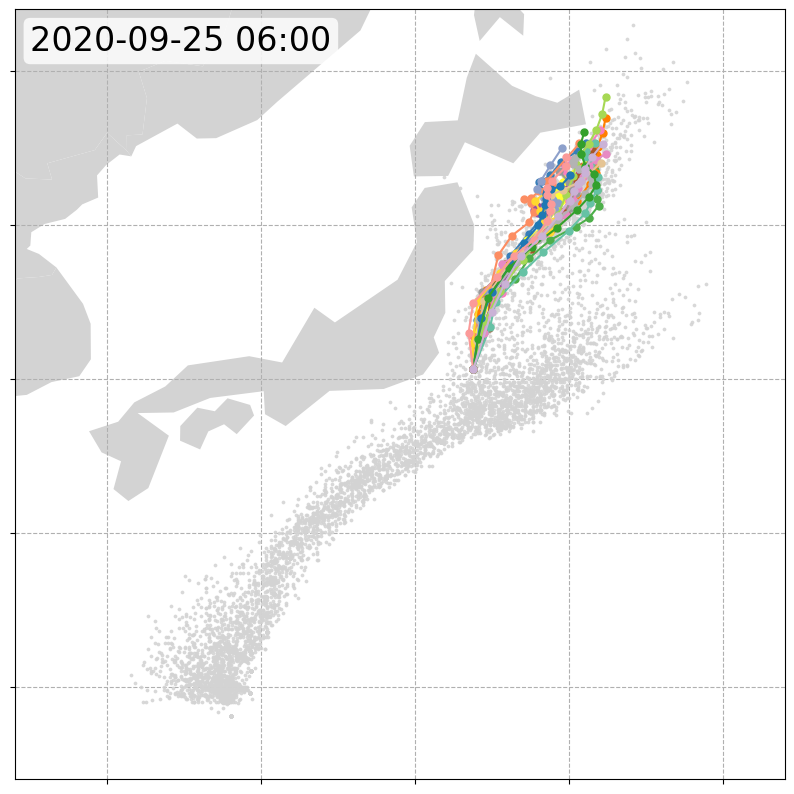

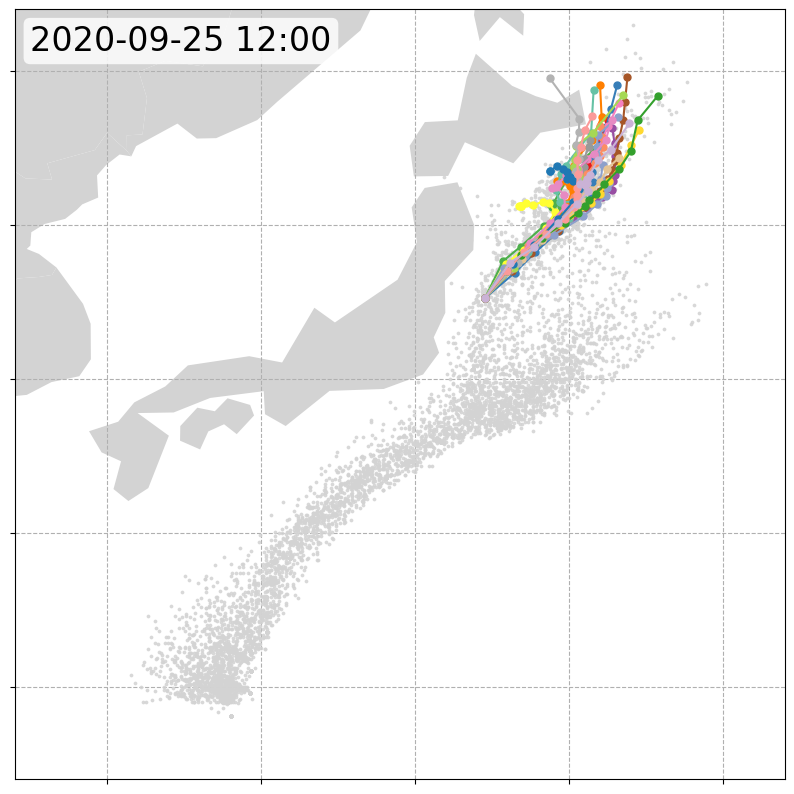

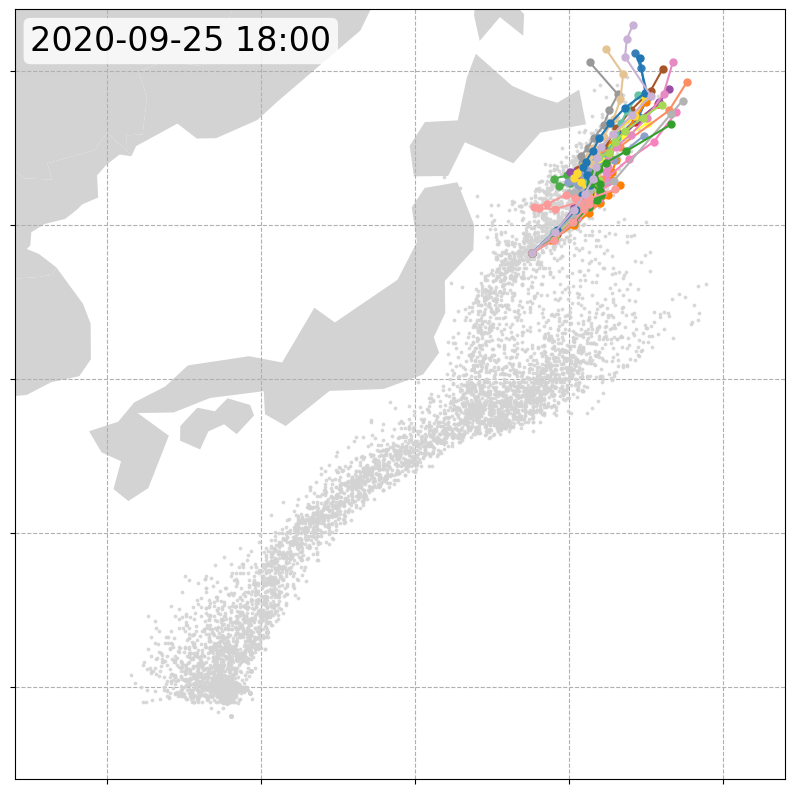

In [38]:
plot_ensemble_by_init_time(adata, long_lim=[127, 152], lati_lim=[22, 47], background=background, colors=ensamble_colors,
                           show_legend=False, show_xlabel=False, show_ylabel=False,show_xticklabels=False, show_yticklabels=False,figsize=(10, 10),
                           save_fig=True, save_fig_dir=OUTPUT_DIR, save_fig_prefix="Dolphin_ensemble_")

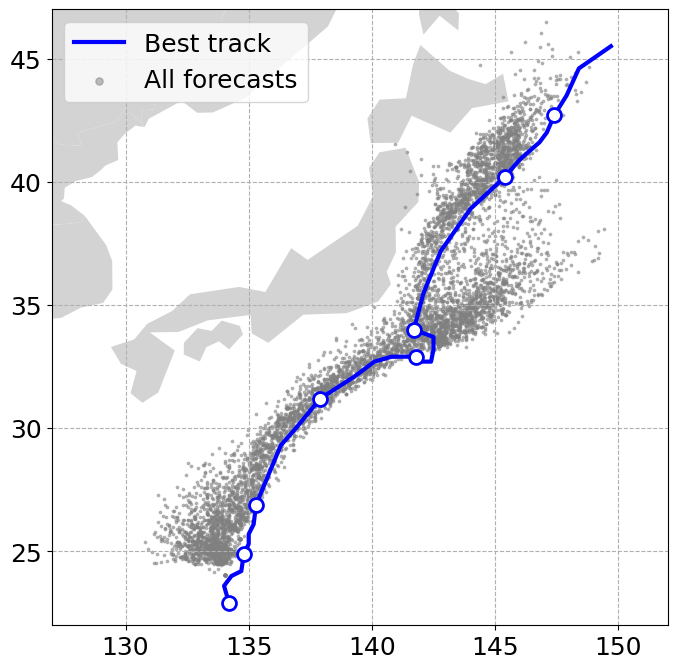

In [39]:
long_lim=[127, 152]
lati_lim=[22, 47]

plt.figure(figsize=(8, 8))
ax = plt.gca()
background.plot(ax=ax, color='lightgray', zorder=0)
ax.plot(best_track_df['lon'], best_track_df['lat'], color='blue', marker='o', markersize=0, label='Best track', zorder=2,lw=3)
ax.scatter(df_input['lon'], df_input['lat'], color='gray', s=3, alpha=0.5, label='All forecasts', zorder=1)
# 日付ラベルを00:00ごとにプロット
for i, dt in enumerate(best_track_df["DateTime"]):
    if "00:00:00" in dt:
        # 日付部分だけ抽出して表示
        date_label = dt.split(" ")[0]
        ax.scatter(best_track_df['lon'].iloc[i], best_track_df['lat'].iloc[i], edgecolor='blue', facecolor="w", marker='o', zorder=10, s=100, linewidths=2)
ax.set_xlim(long_lim)
ax.set_ylim(lati_lim)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18, markerscale=3)
plt.grid(ls="--")
plt.savefig(f"{OUTPUT_DIR}/Dolphin_best_track.png", bbox_inches="tight")
plt.show()


# Numerical experiments with selected one ensamble weather forecasted data

## Select data

In [40]:
time_selected = '2020-09-24 00:00:00'
adata_selected = adata[adata.obs['InitializationTime'] == time_selected]
adata_selected.uns['cost_matrix'] = pairwise_distances(adata_selected.X)
adata_selected.obs = adata_selected.obs.reset_index(drop=True)
adata_selected.obs

InitializationTime         ForecastTime  Horizon  Member         type  \
0    2020-09-24 00:00:00  2020-09-24 00:00:00        0       0  Unperturbed   
1    2020-09-24 00:00:00  2020-09-24 03:00:00        3       0  Unperturbed   
2    2020-09-24 00:00:00  2020-09-24 06:00:00        6       0  Unperturbed   
3    2020-09-24 00:00:00  2020-09-24 09:00:00        9       0  Unperturbed   
4    2020-09-24 00:00:00  2020-09-24 12:00:00       12       0  Unperturbed   
..                   ...                  ...      ...     ...          ...   
289  2020-09-24 00:00:00  2020-09-25 03:00:00       27      20    Perturbed   
290  2020-09-24 00:00:00  2020-09-25 06:00:00       30      20    Perturbed   
291  2020-09-24 00:00:00  2020-09-25 09:00:00       33      20    Perturbed   
292  2020-09-24 00:00:00  2020-09-25 12:00:00       36      20    Perturbed   
293  2020-09-24 00:00:00  2020-09-25 15:00:00       39      20    Perturbed   

        lon    lat             X             Y         prmsl         X1  \
0    142.48  33.92  1.192156e+06  3.778586e+06  98666.390625   8.981105   
1    142.93  33.63  1.236397e+06  3.749473e+06  98916.906250   9.482912   
2    143.45  34.00  1.281410e+06  3.794510e+06  99000.492188   9.993467   
3    143.63  34.25  1.295729e+06  3.823746e+06  99176.101562  10.155880   
4    143.58  34.10  1.292515e+06  3.806653e+06  99192.156250  10.119424   
..      ...    ...           ...           ...           ...        ...   
289  144.26  35.67  1.339221e+06  3.987088e+06  99494.390625  10.649113   
290  144.21  36.46  1.326268e+06  4.074643e+06  99527.750000  10.502187   
291  144.03  37.37  1.300423e+06  4.174388e+06  99542.140625  10.209040   
292  144.37  38.48  1.318092e+06  4.300904e+06  99459.609375  10.409450   
293  145.14  39.42  1.373696e+06  4.412768e+06  99576.617188  11.040149   

           Y1        Xs        Ys                               id1       id2  \
0    5.600975  0.603131  0.150814  20200924000000_20200924013000_00  15_01_00   
1    5.455330  0.711597  0.103401  20200924000000_20200924043000_00  15_02_00   
2    5.680638  0.821955  0.176748  20200924000000_20200924073000_00  15_03_00   
3    5.826899  0.857061  0.224362  20200924000000_20200924103000_00  15_04_00   
4    5.741386  0.849180  0.196524  20200924000000_20200924133000_00  15_05_00   
..        ...       ...       ...                               ...       ...   
289  6.644051  0.963692  0.490381  20200924000000_20200925043000_20  15_10_20   
290  7.082069  0.931933  0.632974  20200924000000_20200925073000_20  15_11_20   
291  7.581068  0.868569  0.795420  20200924000000_20200925103000_20  15_12_20   
292  8.213990  0.911888  1.001464  20200924000000_20200925133000_20  15_13_20   
293  8.773618  1.048215  1.183647  20200924000000_20200925163000_20  15_14_20   

     seq_id  
0       294  
1       294  
2       294  
3       294  
4       294  
..      ...  
289     314  
290     314  
291     314  
292     314  
293     314  

[294 rows x 17 columns]

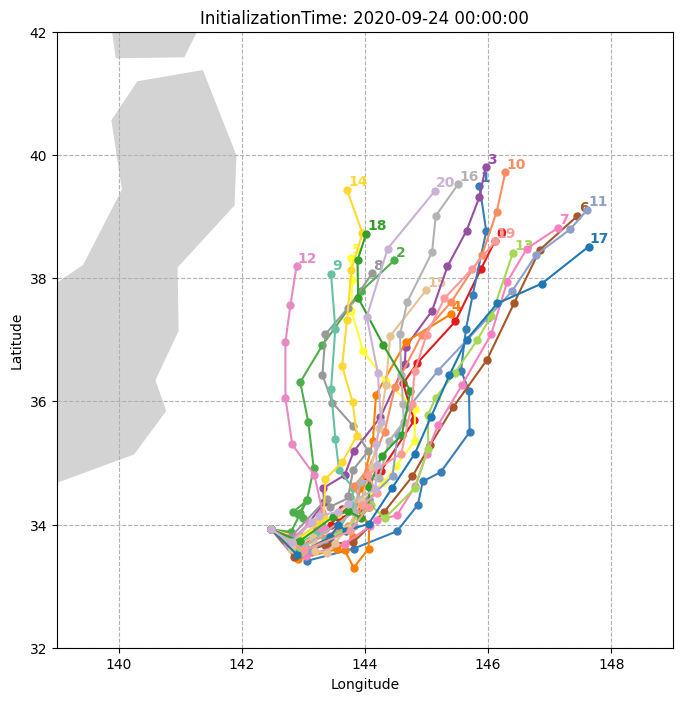

In [41]:
members = sorted(adata_selected.obs['Member'].unique())
plt.figure(figsize=(8, 8))
ax = plt.gca()
background.plot(ax=ax, color='lightgray', zorder=0)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
            '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5',
            '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f',
            '#e5c494', '#b3b3b3', '#1f78b4', '#33a02c', '#fb9a99', '#cab2d6']

for i, member in enumerate(members):
    member_group = adata_selected.obs[adata_selected.obs['Member'] == member].sort_values('ForecastTime')
    ax.plot(member_group['lon'], member_group['lat'], marker='o', markersize=5, color=colors[i],
            label=f'Member {member}', zorder=20)
for i, member in enumerate(members):
    member_group = adata_selected.obs[adata_selected.obs['Member'] == member].sort_values('ForecastTime')
    if not member_group.empty:
        last_row = member_group.iloc[-1]
        ax = plt.gca()
        ax.text(
            last_row['lon']+0.02, last_row['lat']+0.02, str(member),
            fontsize=10, color=colors[i], va='bottom', ha='left', weight='bold'
        )
ax.set_xlim([139, 149])
ax.set_ylim([32, 42])
ax.set_title(f'InitializationTime: {time_selected}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(ls="--", zorder=10)
plt.show()

## Select good cluster

In [42]:
good_members = [6, 7, 11, 17]

last_indices = adata_selected.obs.groupby('Member')['ForecastTime'].idxmax()
good_mask = adata_selected.obs.index.isin(last_indices[adata_selected.obs.loc[last_indices, 'Member'].isin(good_members).values])
bad_mask = adata_selected.obs.index.isin(last_indices[~adata_selected.obs.loc[last_indices, 'Member'].isin(good_members).values])
adata_selected.obs["cluster"] = "Others"
adata_selected.obs.loc[good_mask, "cluster"] = "Good"
adata_selected.obs.loc[bad_mask, "cluster"] = "Bad"

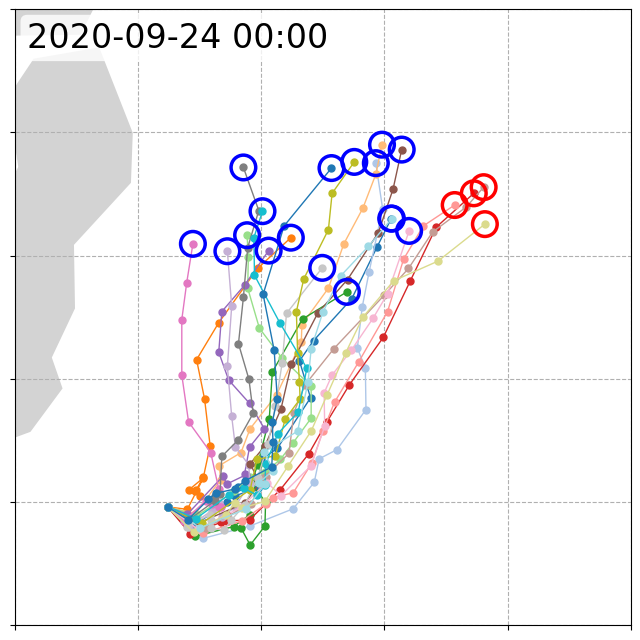

In [43]:
def plot_selected_ensemble(
    adata_selected,
    background,
    time_selected,
    xlim=[140, 150],
    ylim=[32, 42],
    figsize=(8, 8),
    show_labels=True,
    show_xticklabels=True,
    show_yticklabels=True,
    xlabel='Longitude',
    ylabel='Latitude',
    show_grid=True,
    show_time_label=True,
    save_fig=False,
    save_fig_dir=".",
    save_fig_prefix="selected_ensemble_"
):
    """
    Plot selected ensemble members with cluster highlights and save a version without tick labels.

    Parameters
    ----------
    adata_selected : AnnData or DataFrame
        Selected ensemble data with 'Member', 'ForecastTime', 'lon', 'lat', and 'cluster' columns.
    background : GeoDataFrame
        Background map for plotting.
    time_selected : str
        Initialization time string for annotation and filename.
    OUTPUT_DIR : str
        Directory to save the figure.
    xlim : list, default [140, 150]
        Longitude limits.
    ylim : list, default [32, 42]
        Latitude limits.
    figsize : tuple, default (8, 8)
        Figure size.
    show_labels : bool, default True
        Whether to show axis labels.
    show_xticklabels : bool, default True
        Whether to show x tick labels.
    show_yticklabels : bool, default True
        Whether to show y tick labels.
    xlabel : str, default 'Longitude'
        X axis label.
    ylabel : str, default 'Latitude'
        Y axis label.
    show_grid : bool, default True
        Whether to show grid.
    show_time_label : bool, default True
        Whether to show time label on plot.
    save_fig : bool, default True
        Whether to save the figure as a file.
    """
    # First plot: with labels
    plt.figure(figsize=figsize)
    ax = plt.gca()
    background.plot(ax=ax, color='lightgray', zorder=0)

    members = sorted(adata_selected.obs['Member'].unique())
    cmap = plt.get_cmap('tab20')
    member_colors = {m: cmap(i % cmap.N) for i, m in enumerate(members)}

    for member in members:
        member_group = adata_selected.obs[adata_selected.obs['Member'] == member].sort_values('ForecastTime')
        ax.plot(member_group['lon'], member_group['lat'], marker='o', markersize=5,
                color=member_colors[member], label=f'Member {member}', zorder=5, lw=1)

    # Mark the last point of each member according to the cluster
    good_last = adata_selected.obs[adata_selected.obs['cluster'] == "Good"].groupby('Member').tail(1)
    for _, row in good_last.iterrows():
        circle = plt.Circle((row['lon'], row['lat']), 0.2, color='red', fill=False, linewidth=2.5, zorder=20)
        ax.add_patch(circle)

    bad_last = adata_selected.obs[adata_selected.obs['cluster'] == "Bad"].groupby('Member').tail(1)
    for _, row in bad_last.iterrows():
        circle = plt.Circle((row['lon'], row['lat']), 0.2, color='blue', fill=False, linewidth=2.5, zorder=20)
        ax.add_patch(circle)

    if show_time_label:
        ax.text(0.02, 0.98, time_selected[:-3],
                ha='left', va='top', fontsize=24,
                transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2'))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if show_labels:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')
    if not show_xticklabels:
        ax.set_xticklabels([])
    if not show_yticklabels:
        ax.set_yticklabels([])
    if show_grid:
        ax.grid(ls="--", zorder=5)
    else:
        ax.grid(False)
    if save_fig:
        os.makedirs(save_fig_dir, exist_ok=True)
        init_time_modified = time_selected.replace(' ', '_').split(':')[0]
        plt.savefig(f"{save_fig_dir}/{save_fig_prefix}{init_time_modified}.png", bbox_inches="tight")
    plt.show()

plot_selected_ensemble(adata_selected, background, time_selected, 
                       save_fig=True, save_fig_dir=OUTPUT_DIR,
                       save_fig_prefix="Dolphin_ensemble_selected_",
                       show_labels=False, show_xticklabels=False, show_yticklabels=False)

## Compute $\varepsilon$- and $\varepsilon_\Sigma$-attracting basin

In [44]:
epsbasin.eps_attracting_basin(adata_selected, target_cluster_key = "Good")
epsbasin.eps_attracting_basin(adata_selected, target_cluster_key = "Bad")
epsbasin.eps_sum_attracting_basin(adata_selected, target_cluster_key = "Good")
epsbasin.eps_sum_attracting_basin(adata_selected, target_cluster_key = "Bad")

## Plot $\varepsilon$-attracting basins for good and bad clusters.

eps_threshold = 0.0


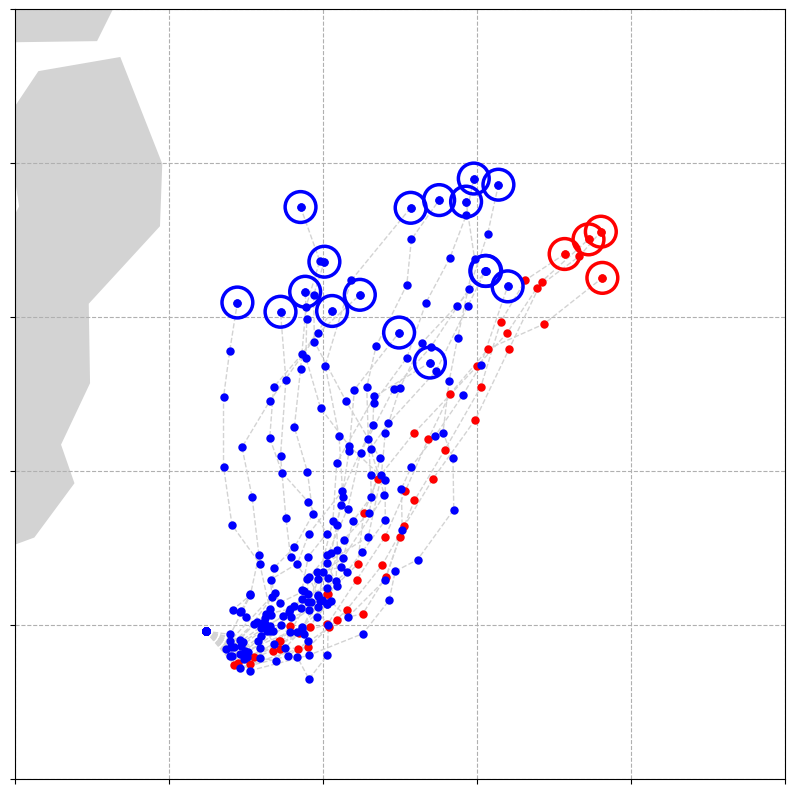

eps_threshold = 0.1


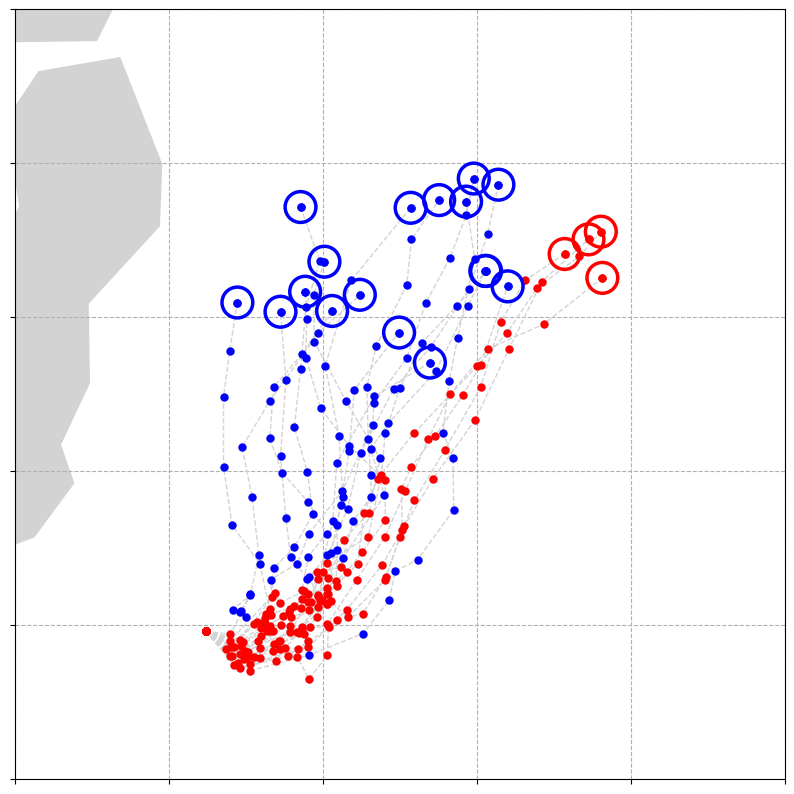

eps_threshold = 0.2


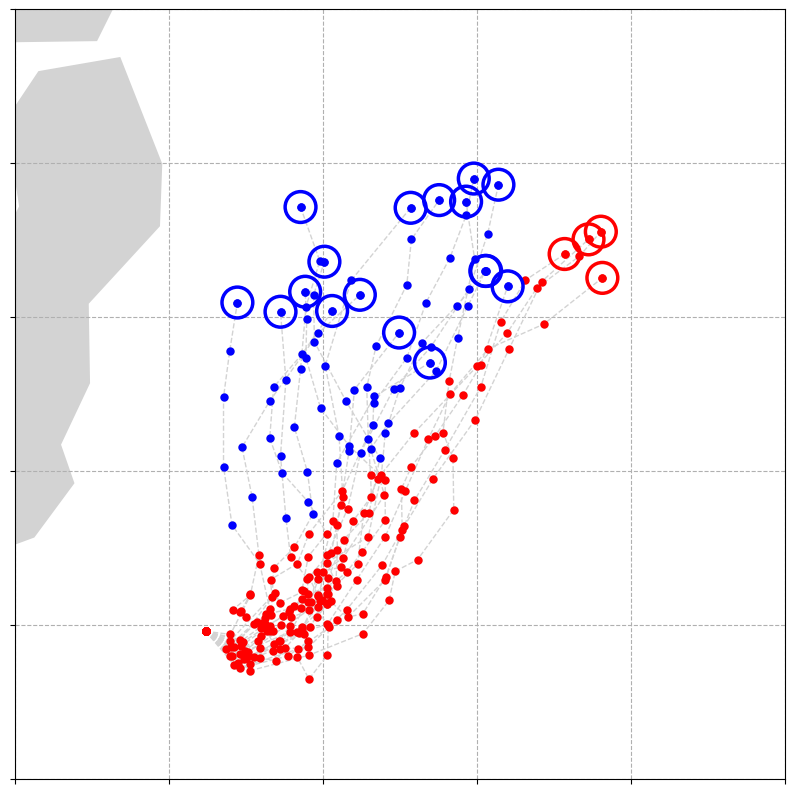

eps_threshold = 0.30000000000000004


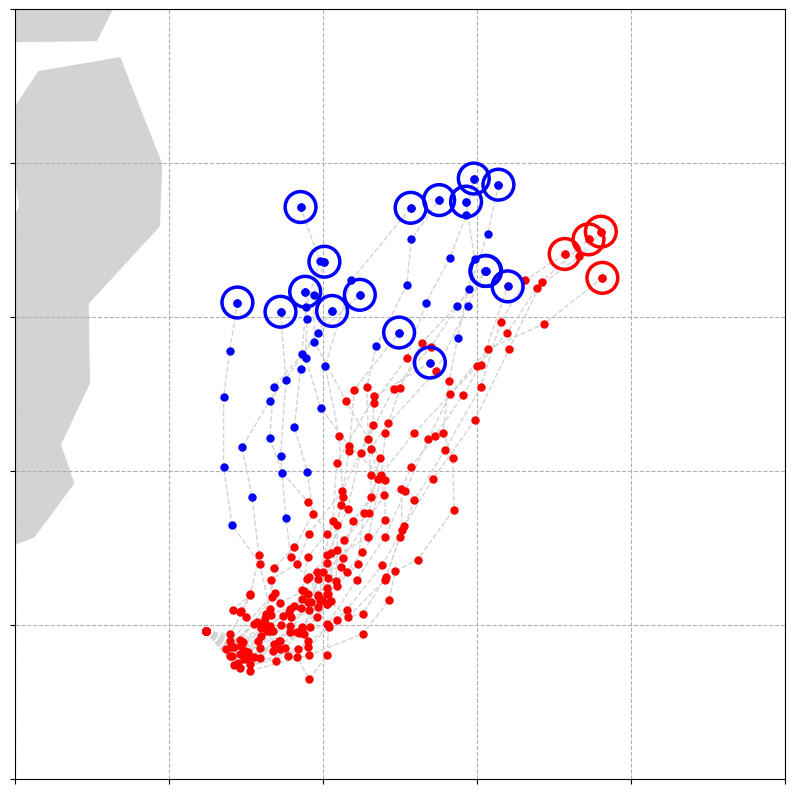

eps_threshold = 0.4


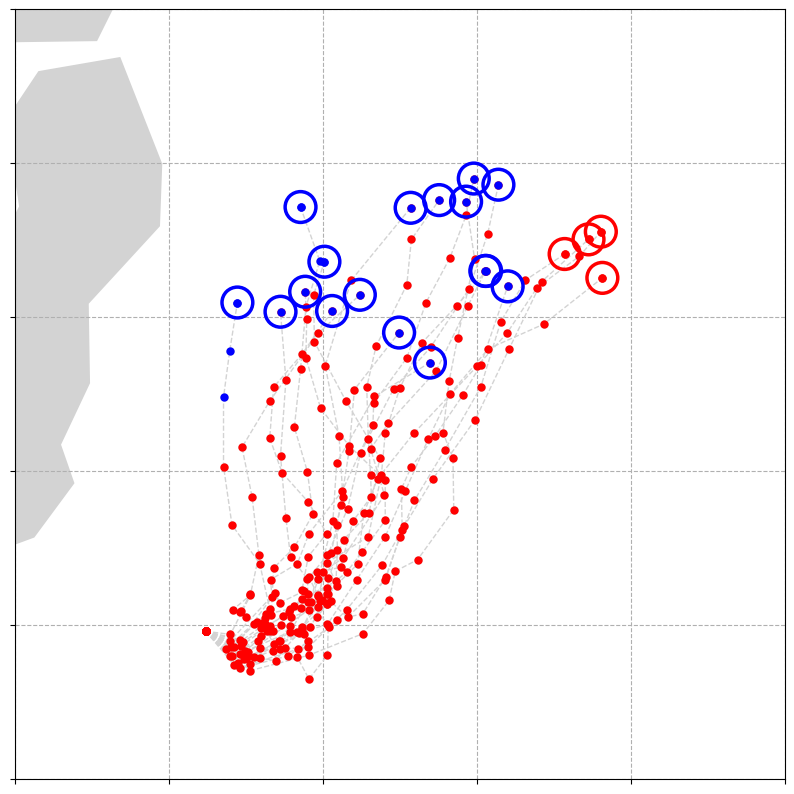

eps_threshold = 0.5


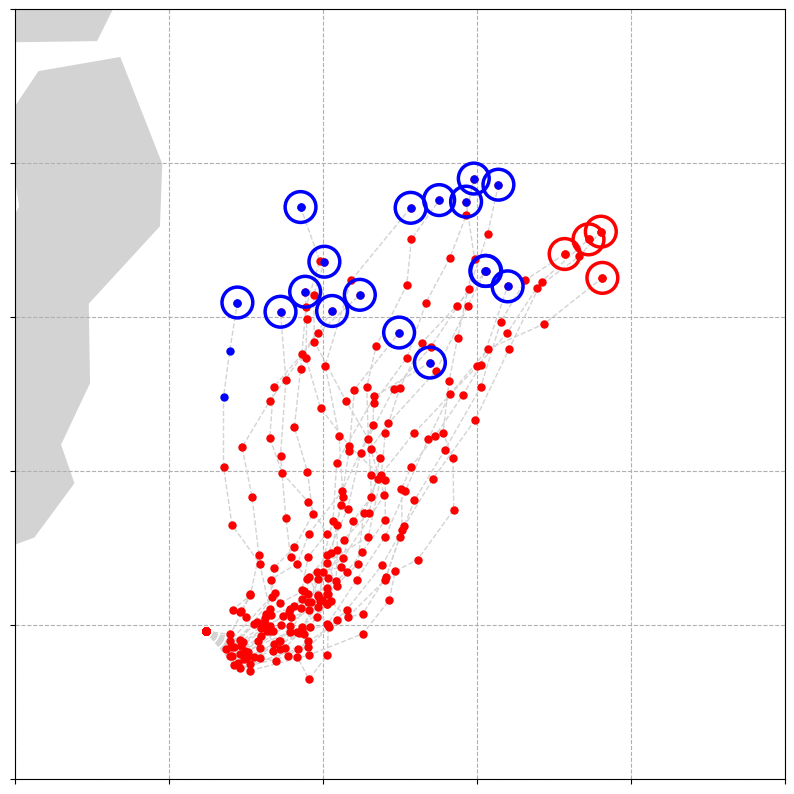

eps_threshold = 0.6000000000000001


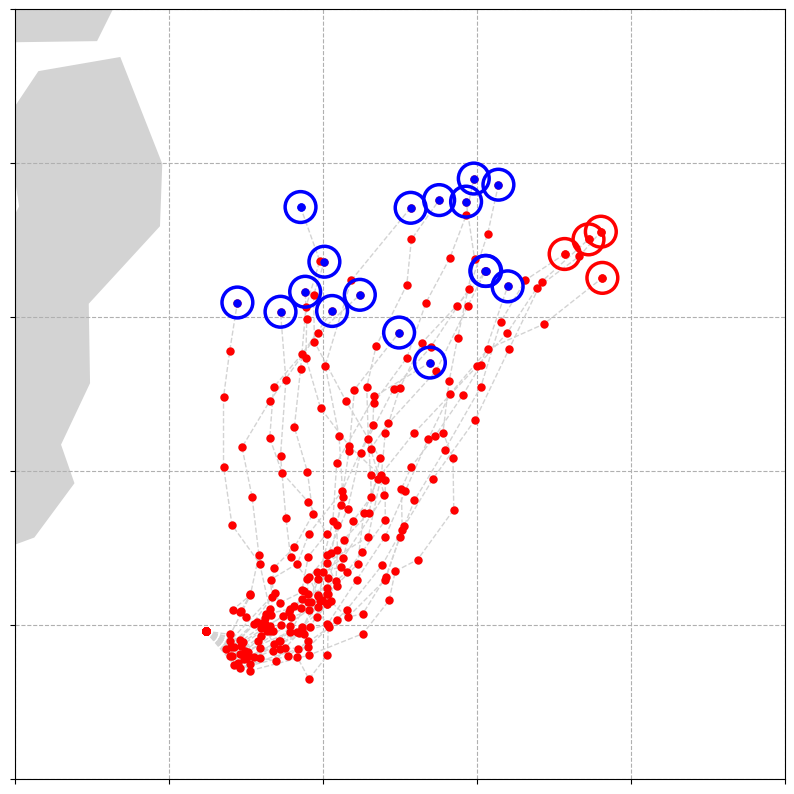

eps_threshold = 0.7000000000000001


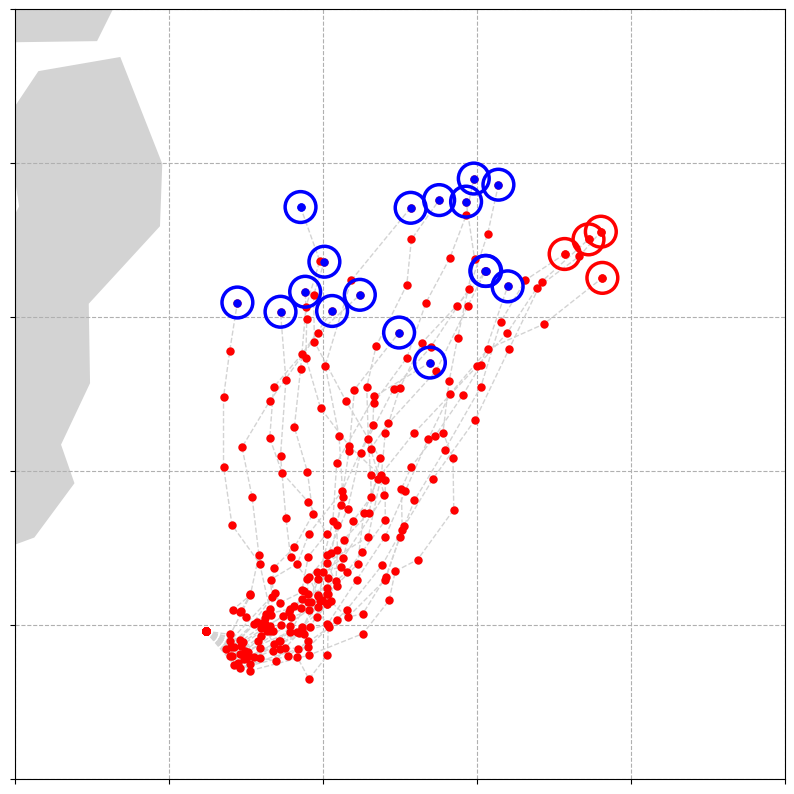

eps_threshold = 0.8


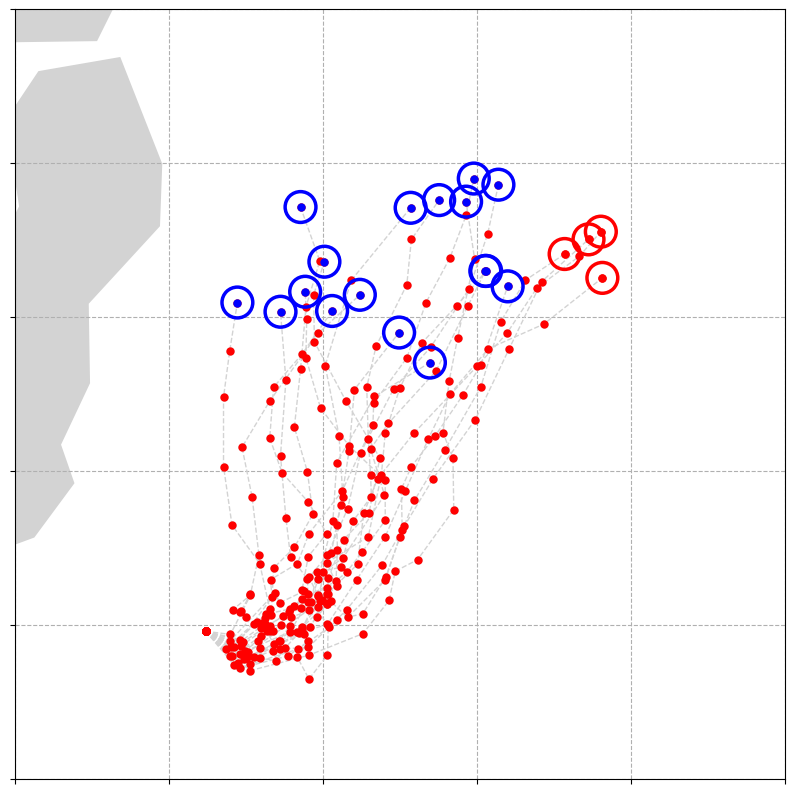

eps_threshold = 0.9


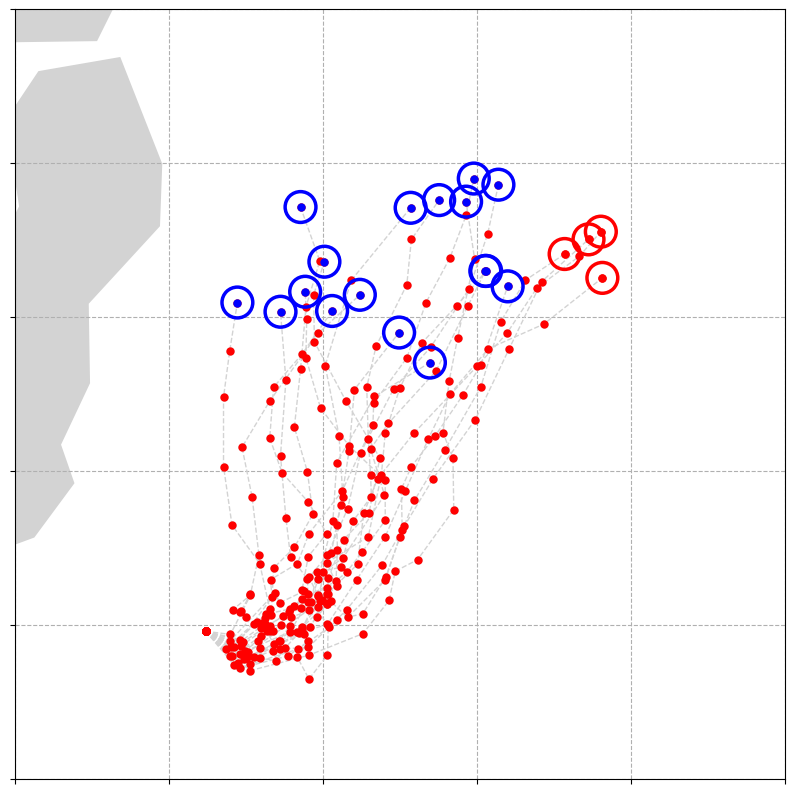

eps_threshold = 1.0


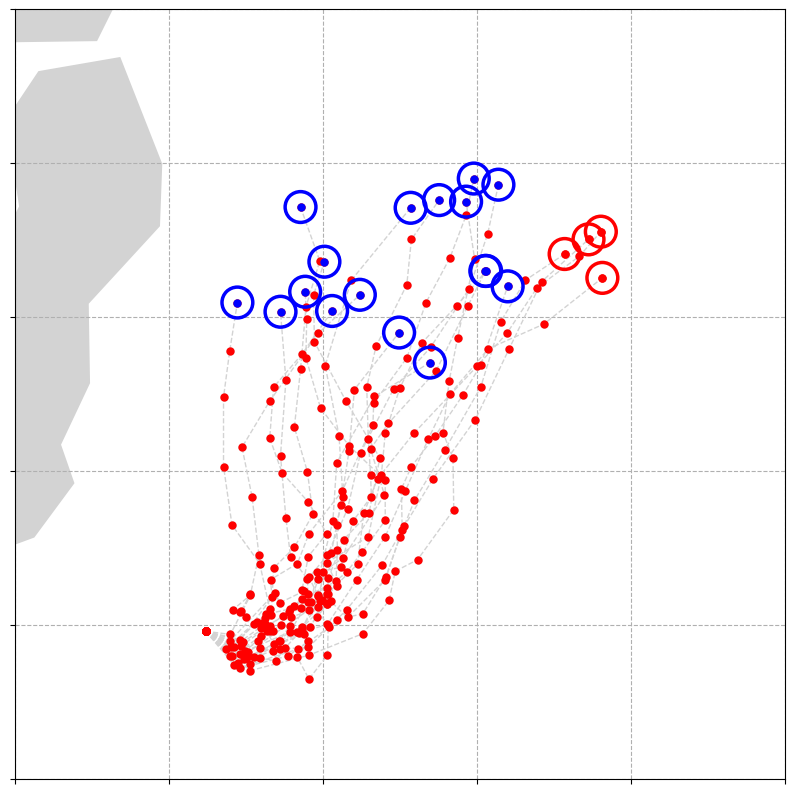

In [45]:
eps_thresholds = np.arange(0, 1.05, 0.1)
for eps_threshold in eps_thresholds:
    print(f"eps_threshold = {eps_threshold}")
    epsbasin.plot_attracting_basin(adata_selected, eps_key="eps_attracting_basin", good_cluster_key="Good", bad_cluster_key="Bad", 
                          eps_threshold=eps_threshold, background=background, lon_lim=[140,150], lat_lim=[32,42],
                          show_legend=False, show_label=False,show_title=False,
                          save_fig=True, save_fig_dir=OUTPUT_DIR, save_fig_name="Dolphin_eps_attracting_basin")

## Plot $\varepsilon_\Sigma$-attracting basins for good and bad clusters

eps_threshold = 0.0


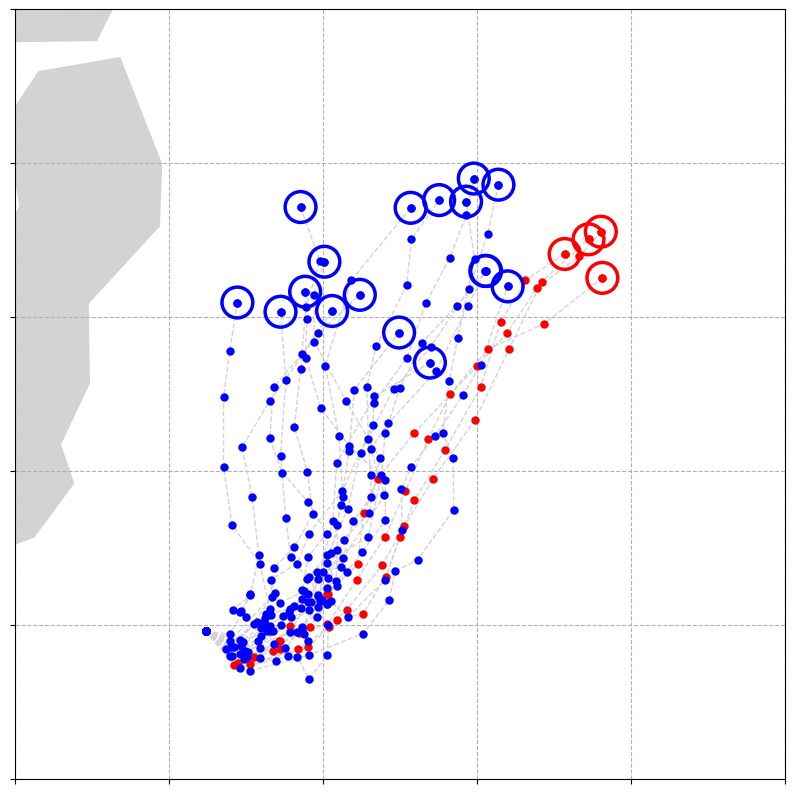

eps_threshold = 0.2


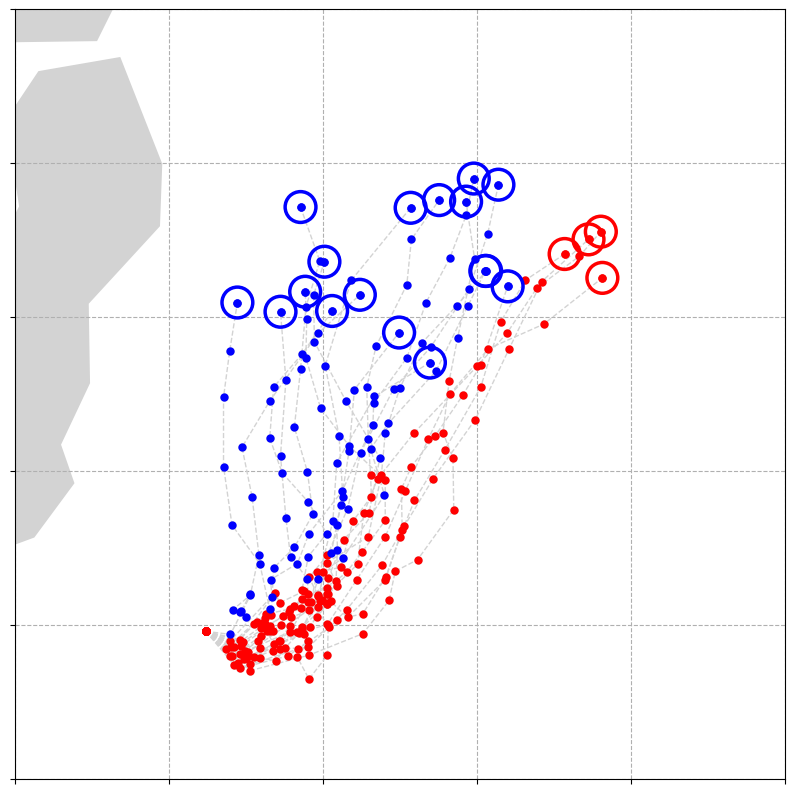

eps_threshold = 0.4


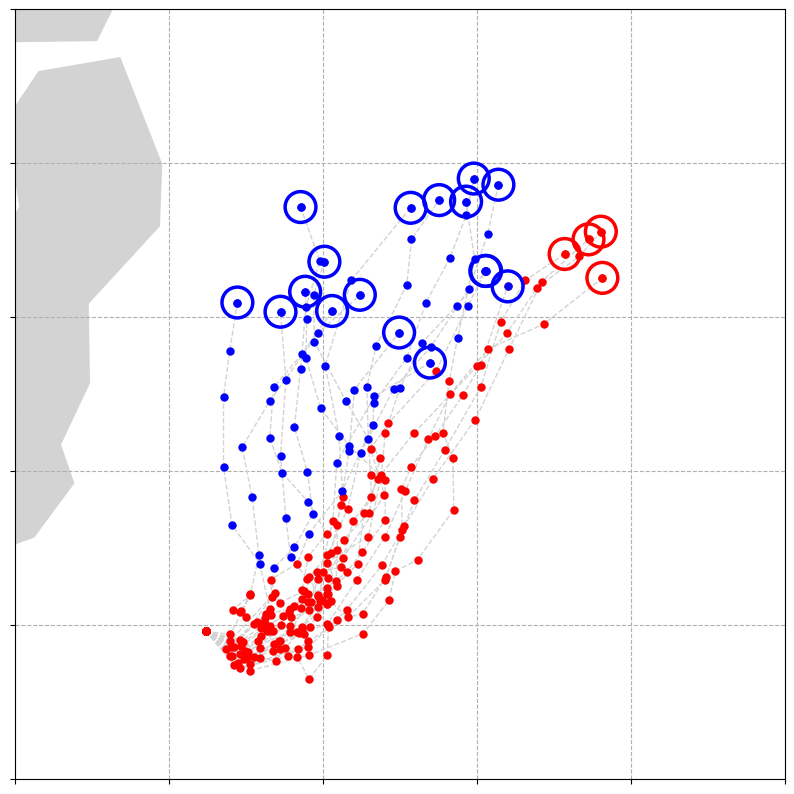

eps_threshold = 0.6000000000000001


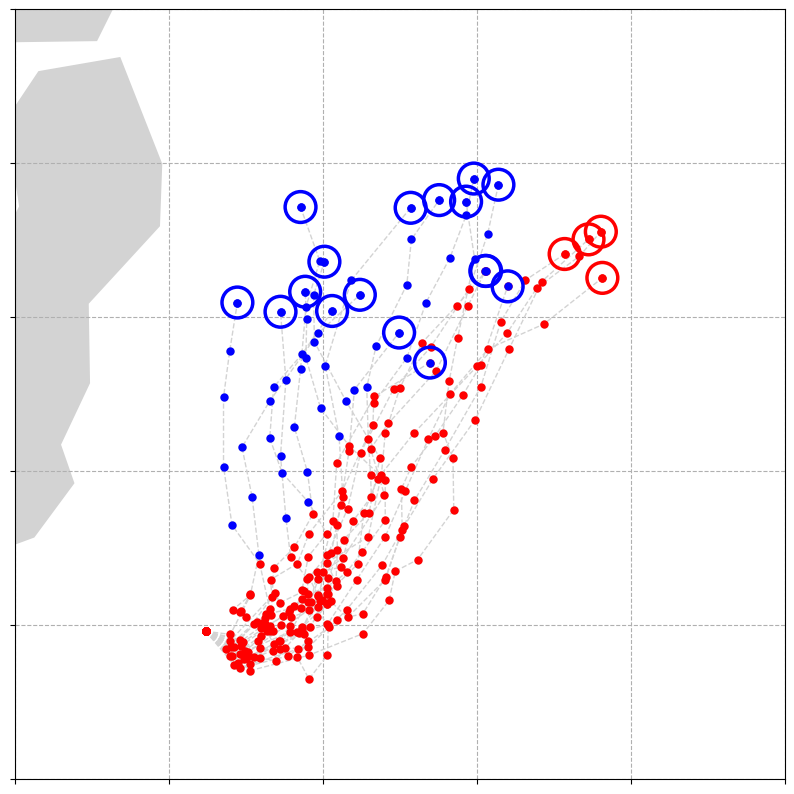

eps_threshold = 0.8


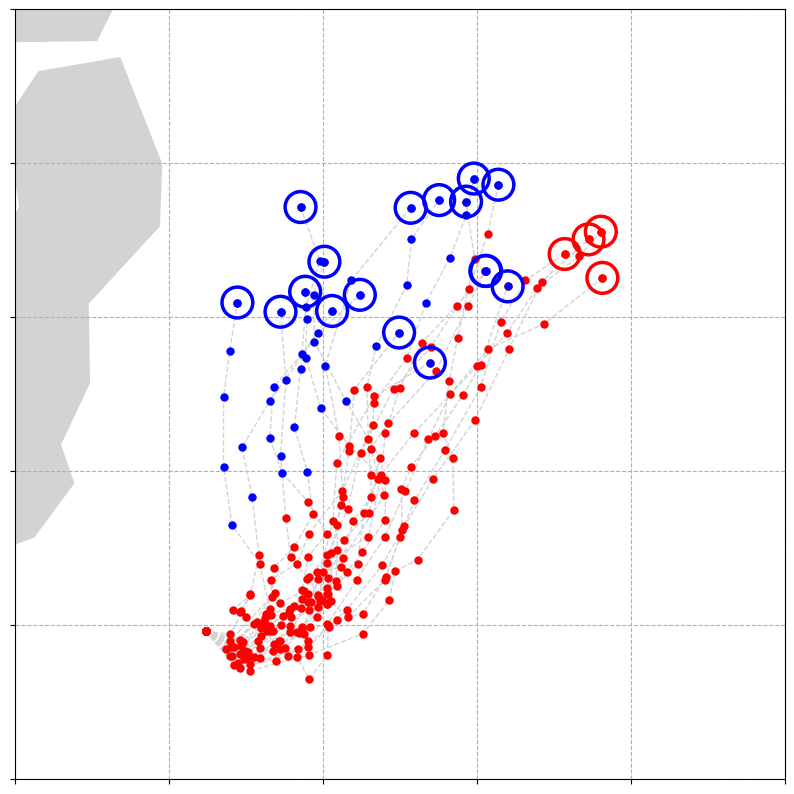

eps_threshold = 1.0


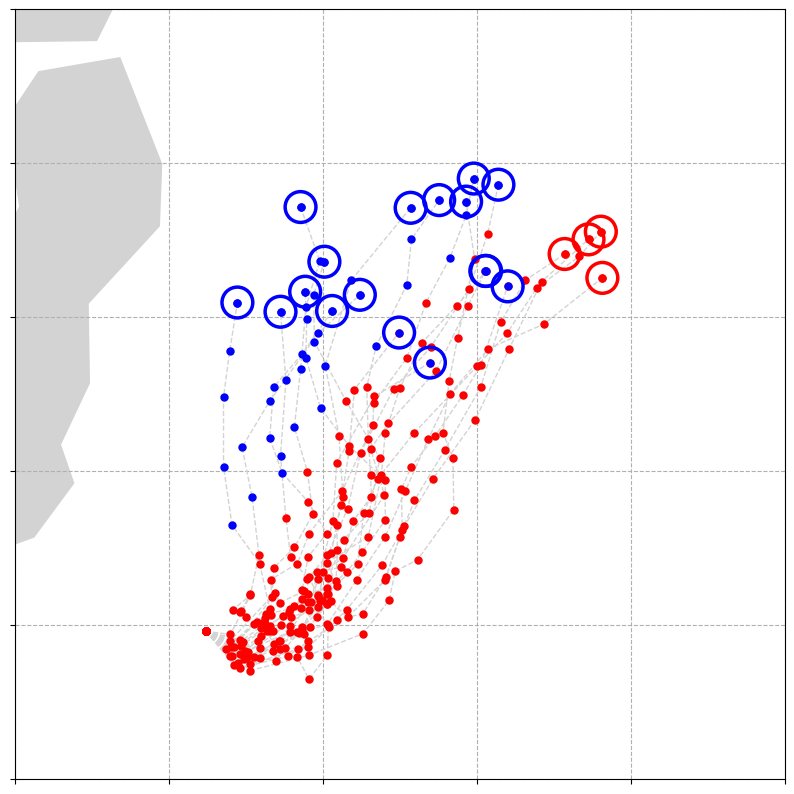

eps_threshold = 1.2000000000000002


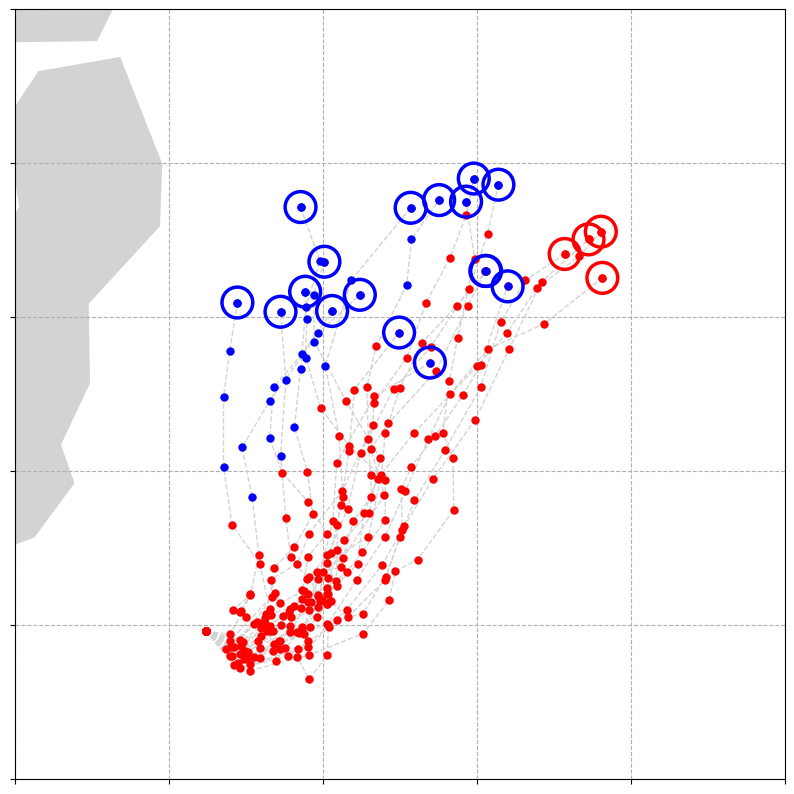

eps_threshold = 1.4000000000000001


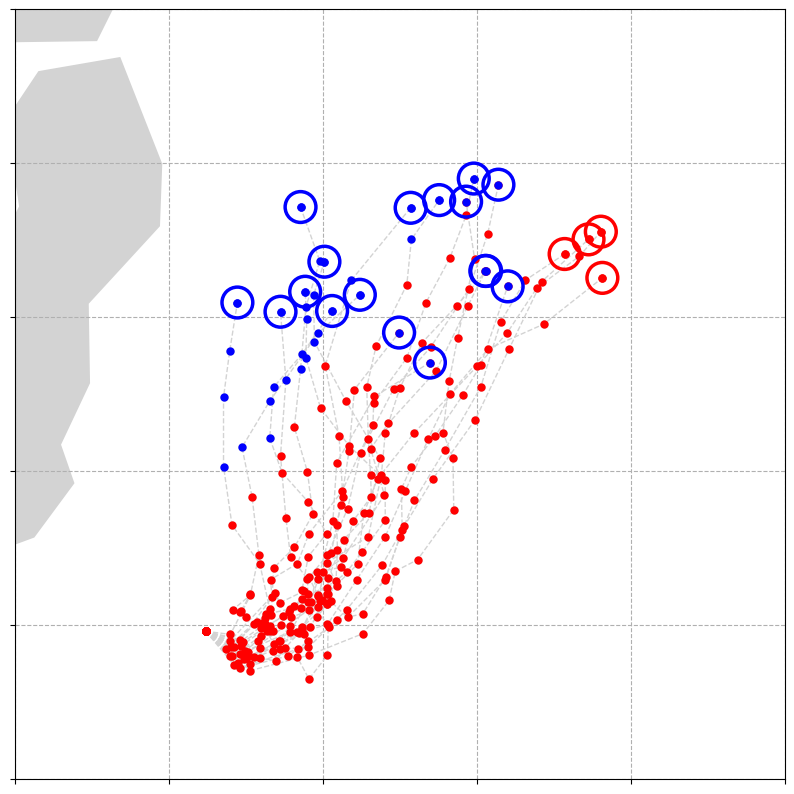

eps_threshold = 1.6


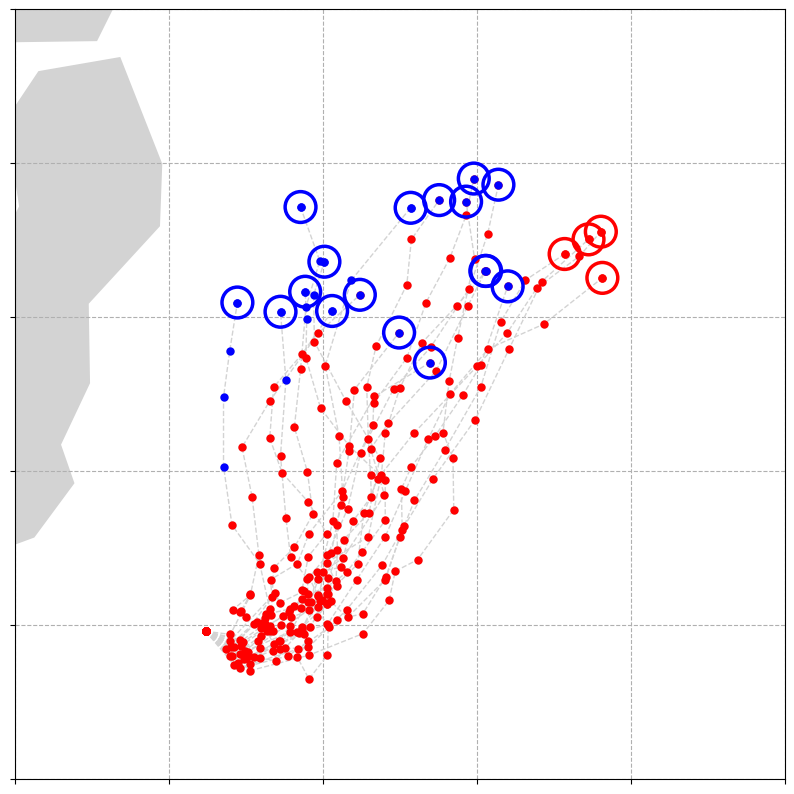

eps_threshold = 1.8


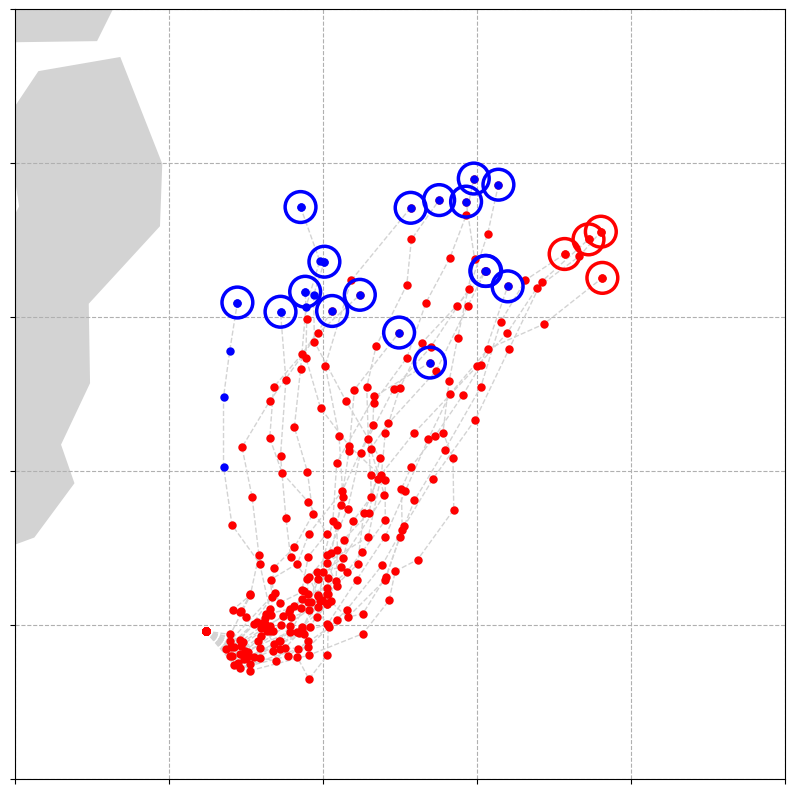

eps_threshold = 2.0


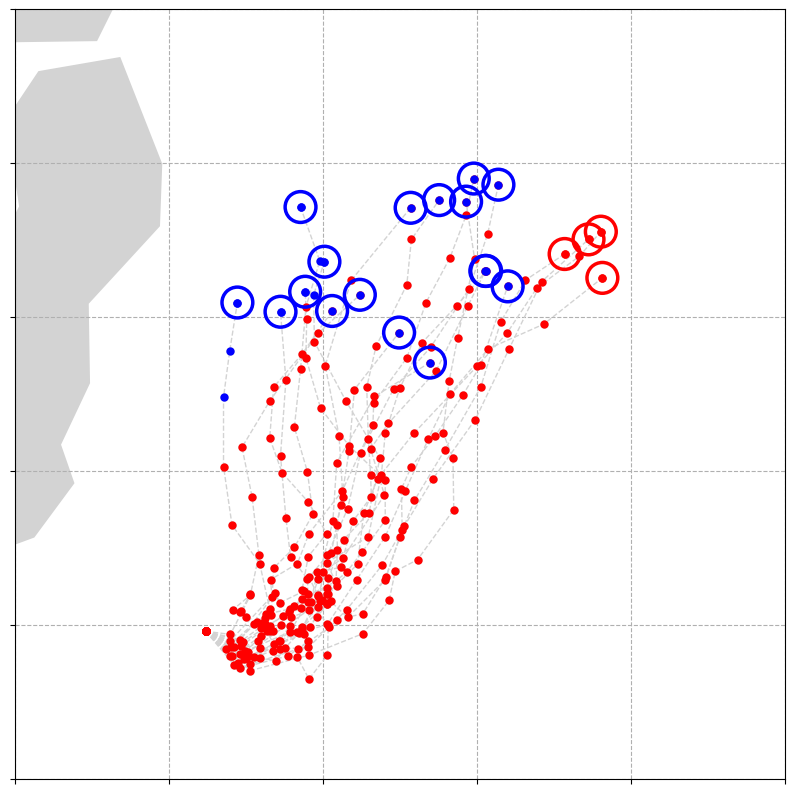

eps_threshold = 2.2


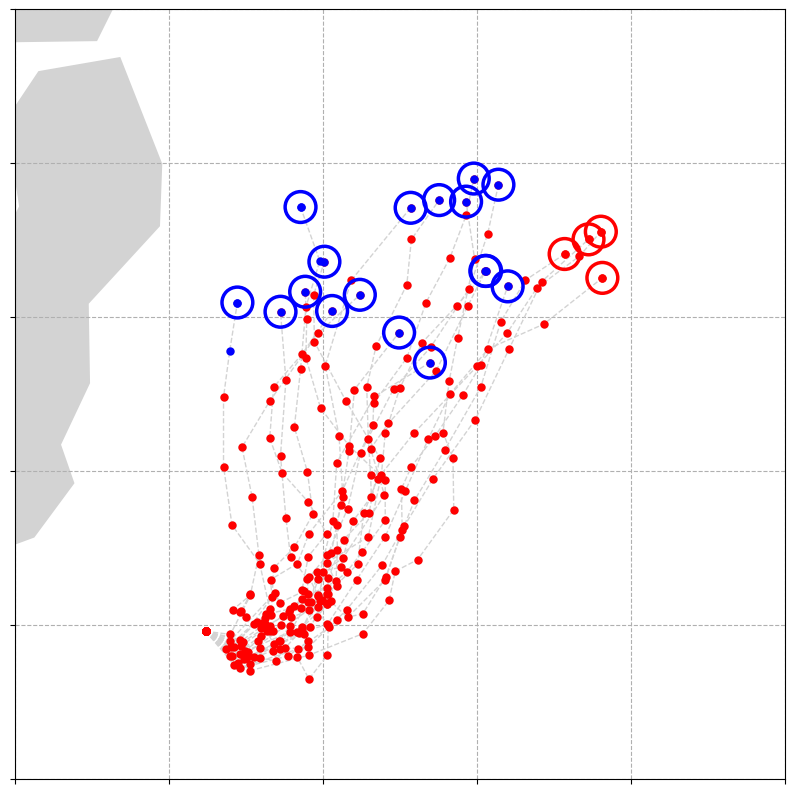

eps_threshold = 2.4000000000000004


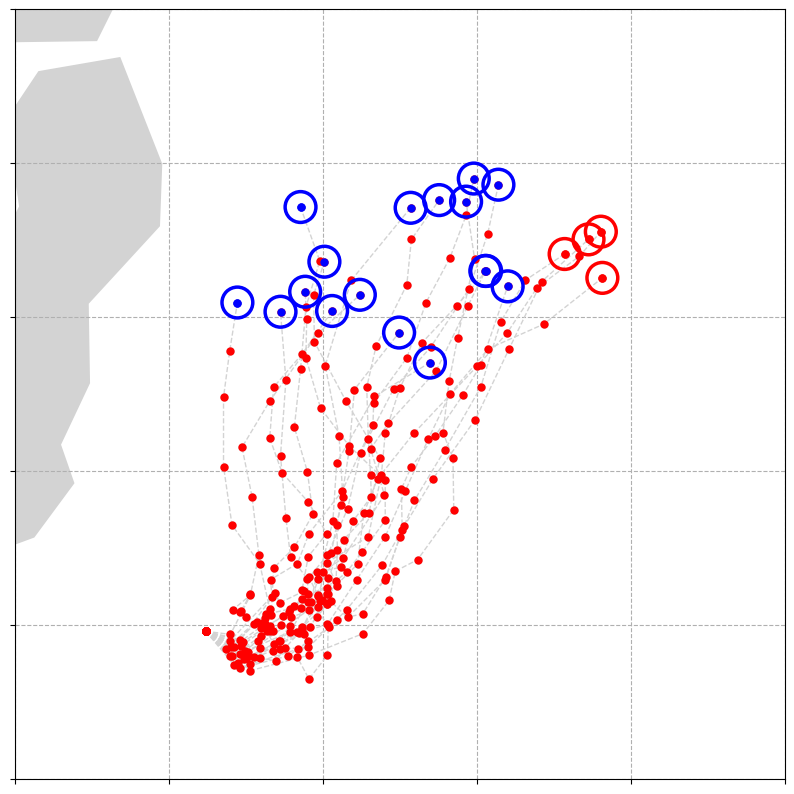

eps_threshold = 2.6


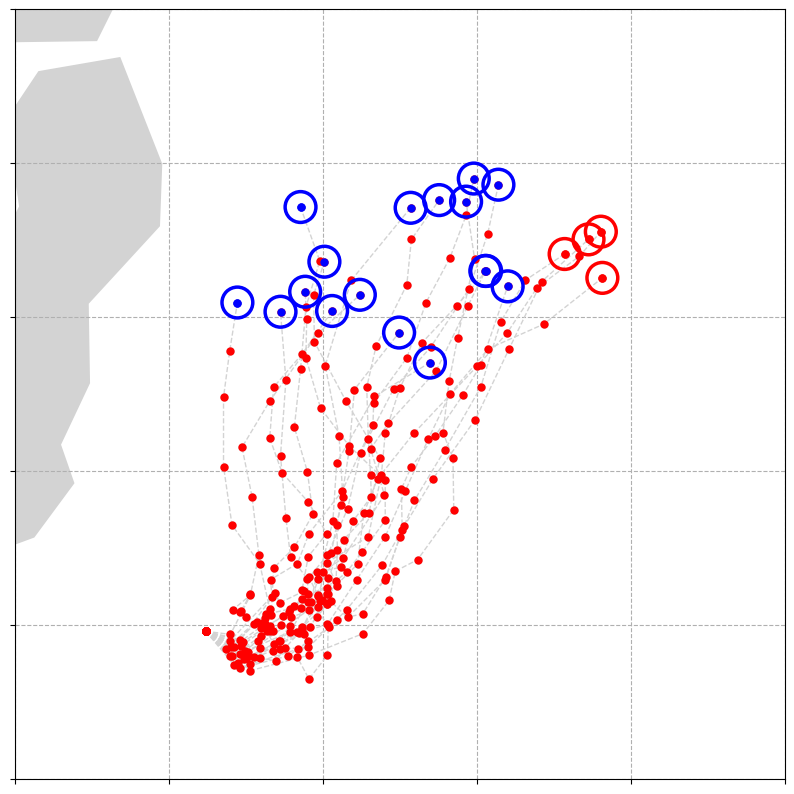

eps_threshold = 2.8000000000000003


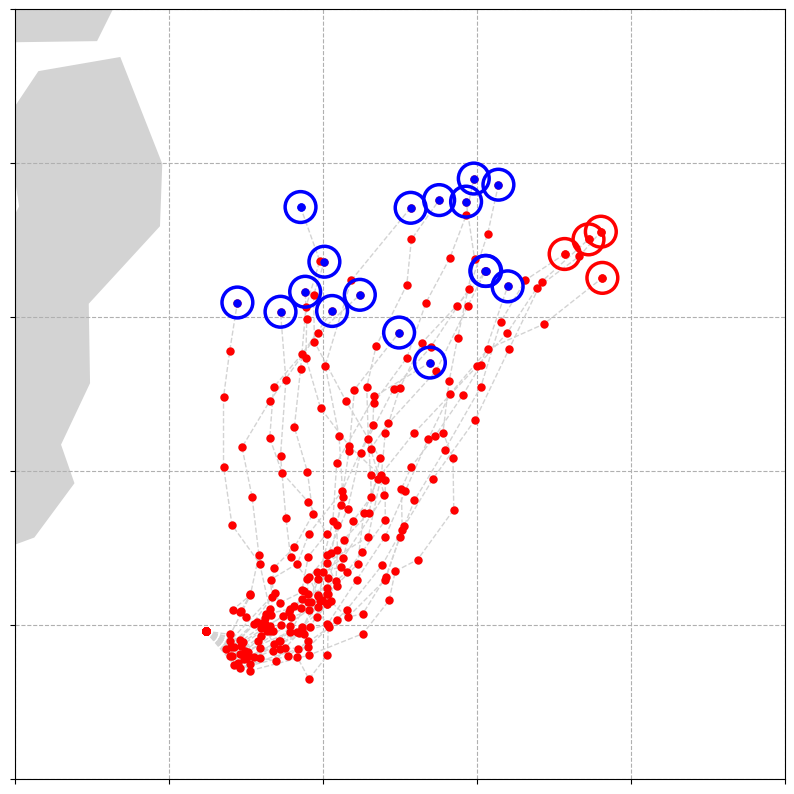

eps_threshold = 3.0


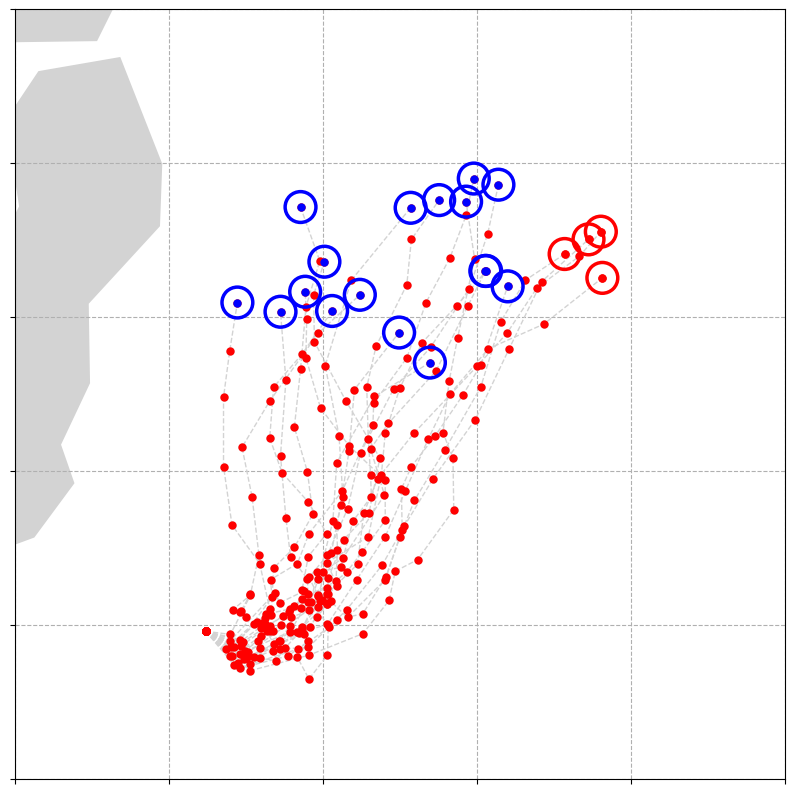

In [46]:
eps_thresholds = np.arange(0, 3.05, 0.2)
for eps_threshold in eps_thresholds:
    print(f"eps_threshold = {eps_threshold}")
    epsbasin.plot_attracting_basin(adata_selected, eps_key="eps_sum_attracting_basin", good_cluster_key="Good", bad_cluster_key="Bad", 
                          eps_threshold=eps_threshold, background=background, lon_lim=[140,150], lat_lim=[32,42],
                          show_legend=False, show_label=False,show_title=False,
                          save_fig=True, save_fig_dir=OUTPUT_DIR, save_fig_name="Dolphin_eps_sum_attracting_basin")

## Plot debut functions $\underline\varepsilon$ and $\underline\varepsilon_\Sigma$ for each track

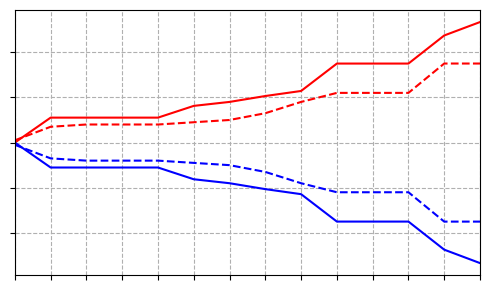

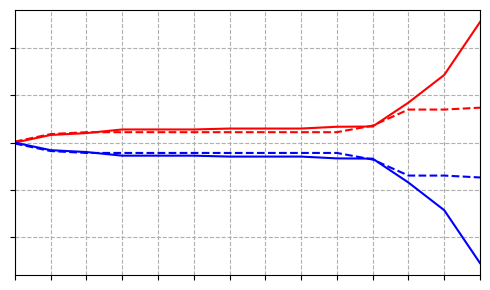

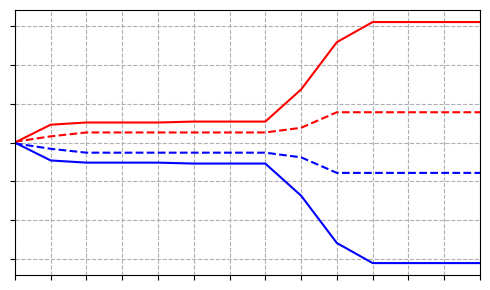

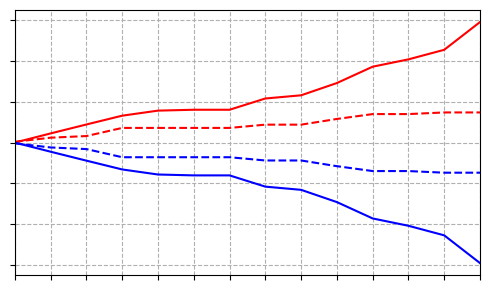

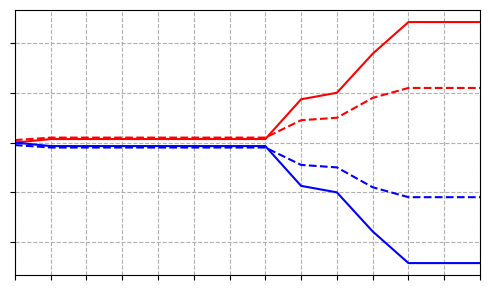

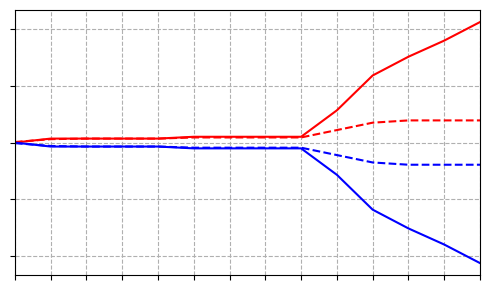

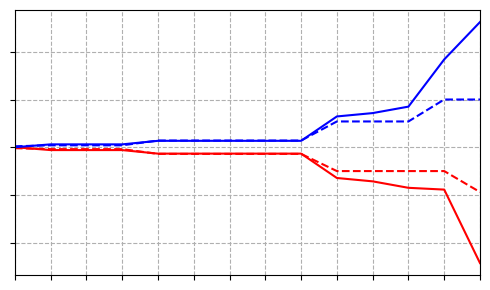

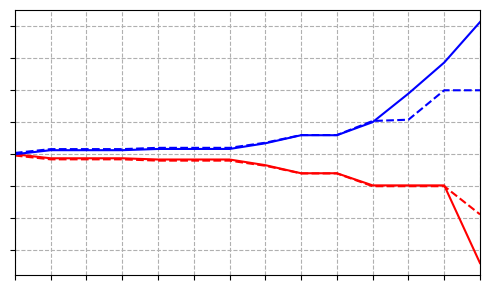

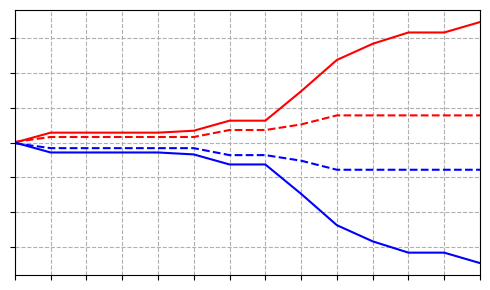

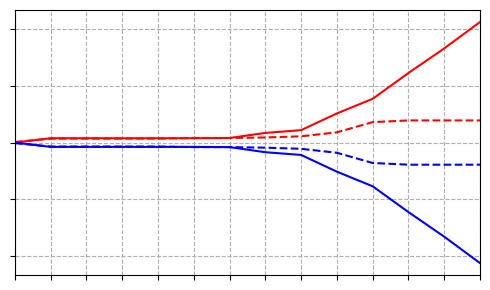

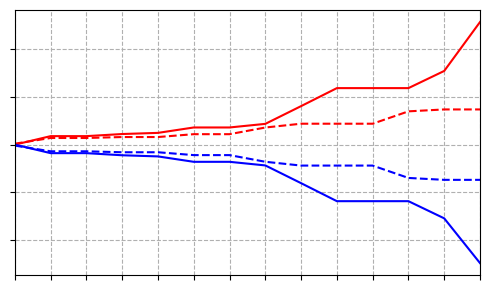

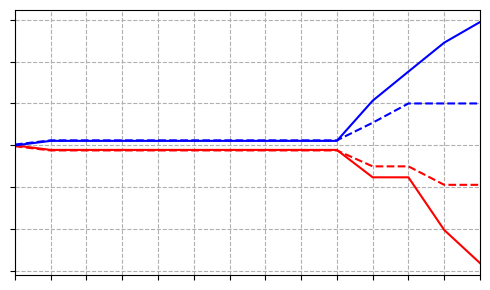

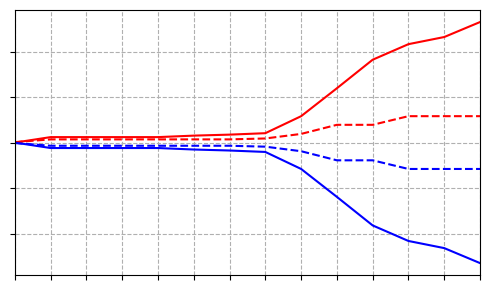

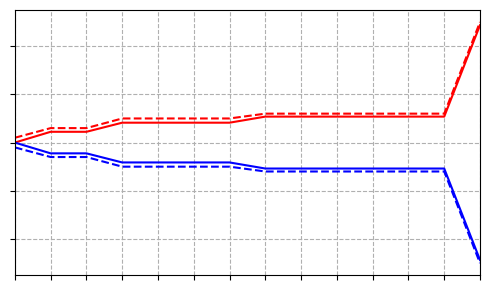

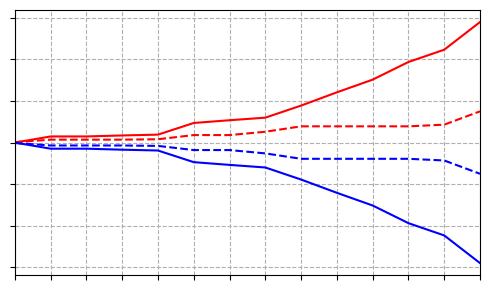

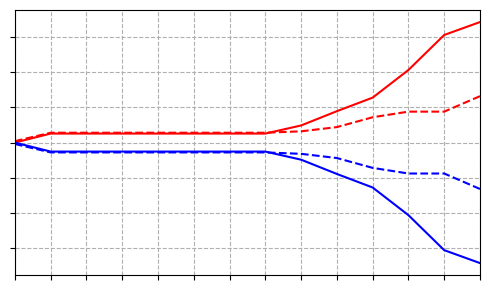

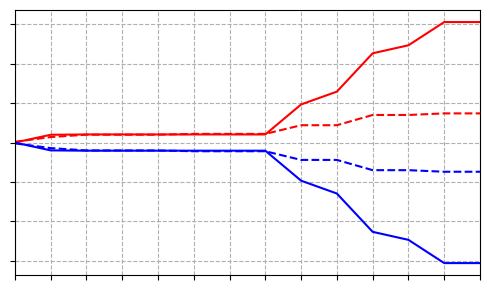

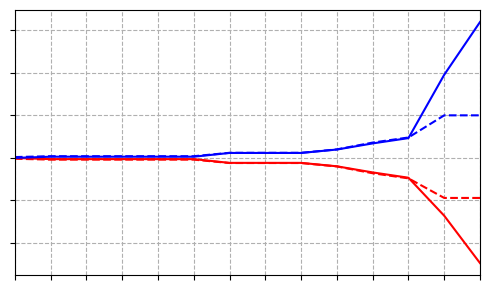

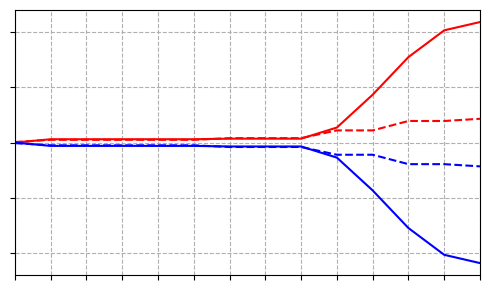

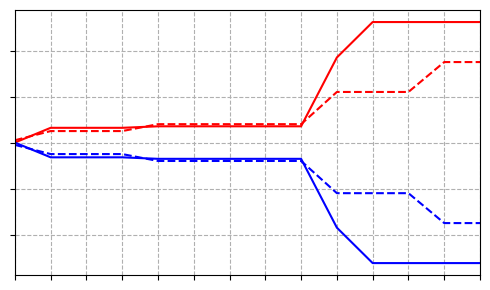

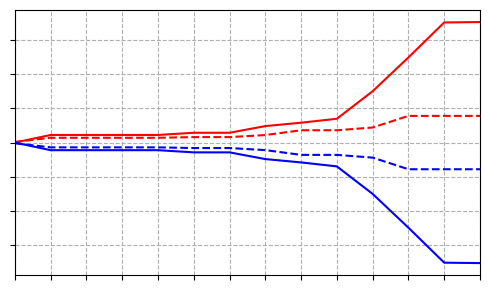

In [47]:
def plot_member_debut_functions(
    adata, 
    member_key="Member",
    show_title=True,
    show_xlabel=True,
    show_ylabel=True,
    show_legend=True,
    show_xticklabels=True,
    show_yticklabels=True,
    save_fig=False,
    save_fig_dir=".",
    save_fig_name="debut_functions",
    figsize=(8, 4)
):
    """
    Plot debut functions (eps_attracting_basin_Good/Bad, eps_sum_attracting_basin_Good/Bad) for each member.

    Parameters
    ----------
    adata : AnnData
        AnnData object with .obs containing debut function columns.
    member_key : str, default "Member"
        Column name for member IDs.
    show_title : bool, default True
        Whether to show the plot title.
    show_xlabel : bool, default True
        Whether to show the x-axis label.
    show_ylabel : bool, default True
        Whether to show the y-axis label.
    show_legend : bool, default True
        Whether to show the legend.
    show_xticklabels : bool, default True
        Whether to show x-axis tick labels.
    show_yticklabels : bool, default True
        Whether to show y-axis tick labels.
    save_fig : bool, default False
        Whether to save the figure.
    save_fig_dir : str, default "."
        Directory to save the figure.
    save_fig_name : str, default "sublevel_set_visualization"
        Base filename for saved figures.
    figsize : tuple, default (8, 4)
        Figure size for the plot.
    """
    members = np.unique(adata.obs[member_key].values)
    plot_x = ["Sep."+str(s)[8:10]+" "+str(s)[11:16] for s in np.unique(adata.obs['ForecastTime'].values)]
    for member in members:
        member_group = adata.obs[adata.obs[member_key] == member].sort_values('ForecastTime')
        times = pd.to_datetime(member_group['ForecastTime'])
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(plot_x, member_group['eps_attracting_basin_Good'], label="$\_\\varepsilon(\cdot; G)$", color='r', ls="--")
        ax.plot(plot_x, member_group['eps_attracting_basin_Bad'], label="$\_\\varepsilon(\cdot; B)$", color='b', ls="--")
        ax.plot(plot_x, member_group['eps_sum_attracting_basin_Good'], label="$\_\\varepsilon_\\Sigma(\cdot; G)$", color='r', ls="-")
        ax.plot(plot_x, member_group['eps_sum_attracting_basin_Bad'], label="$\_\\varepsilon_\\Sigma(\cdot; B)$", color='b', ls="-")
        if show_title:
            ax.set_title(f"Member {member}", fontsize=16)
        if show_xlabel:
            ax.set_xlabel("ForecastTime", fontsize=14)
        if show_ylabel:
            ax.set_ylabel("Value", fontsize=14)
        ax.grid(ls="--")
        if show_legend:
            ax.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
        if show_xticklabels:
            ax.set_xticklabels(plot_x, rotation=90, fontsize=12)
        else:
            ax.set_xticklabels([])
        if show_yticklabels:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
        else:
            ax.set_yticklabels([])
        fig.tight_layout()
        # Reduce x-axis left/right margin
        # ax.set_xlim(times.min(), times.max())
        ax.set_xlim(0, len(plot_x) - 1)
        if save_fig:
            os.makedirs(save_fig_dir, exist_ok=True)
            if isinstance(member, (int, np.integer)):
                member_ = f"{member:02d}"
            else:
                member_ = str(member)
            fig.savefig(f"{save_fig_dir}/{save_fig_name}_{member_}.png", bbox_inches="tight")
        plt.show()

plot_member_debut_functions(adata_selected,show_title=False,
    show_xlabel=False,
    show_ylabel=False,
    show_legend=False,
    show_xticklabels=False,
    show_yticklabels=False,
    figsize=(5, 3),
    save_fig=True,
    save_fig_dir=OUTPUT_DIR,
    save_fig_name="Dolphin_selected_debut_function",
    )

# Numerical experiments with whole ensamble weather forecasted data

## K-means clustering

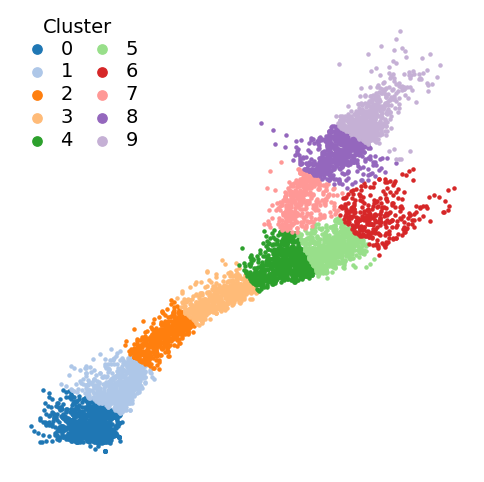

In [48]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
adata.obs['cluster'] = kmeans.fit_predict(adata.X)

cluster_means = adata.obs.groupby('cluster')['lat'].mean().sort_values()
cluster_map = {old: new for new, old in enumerate(cluster_means.index)}
adata.obs['cluster'] = adata.obs['cluster'].map(cluster_map)

plt.figure(figsize=(6, 6))
cmap = plt.get_cmap('tab20')
for cluster_id in sorted(adata.obs['cluster'].unique()):
    mask = adata.obs['cluster'] == cluster_id
    plt.scatter(adata.X[mask, 0], adata.X[mask, 1],
                s=5, c=[cmap(cluster_id % 20)], label=f'{cluster_id}')
legend = plt.legend(
    title='Cluster',
    bbox_to_anchor=(0.0, 1),
    loc='upper left',
    borderaxespad=0.,
    ncol=2,
    markerscale=3,
    frameon=False,
    fontsize=14,
    title_fontsize=14,  # タイトルのフォントサイズを大きく
    handletextpad=0.2,   # マーカーとテキストの間隔を狭く
    columnspacing=0.5,    # 列間のスペースを狭く
    labelspacing=0.2,
)
legend._legend_box.sep = 2 
plt.axis("off")
plt.savefig(f"{OUTPUT_DIR}/Dolphin_clusters.png", bbox_inches="tight")
plt.show()

In [49]:
good_cluster_key = 6
bad_cluster_key = 9

## Compute $\varepsilon$- and $\varepsilon_\Sigma$-attracting basin

In [50]:
epsbasin.eps_attracting_basin(adata, target_cluster_key=good_cluster_key)
epsbasin.eps_attracting_basin(adata, target_cluster_key=bad_cluster_key)
epsbasin.eps_sum_attracting_basin(adata, target_cluster_key=good_cluster_key)
epsbasin.eps_sum_attracting_basin(adata, target_cluster_key=bad_cluster_key)

## Sublevel set visualization of $\varepsilon$- and $\varepsilon_\Sigma$-attracting basin

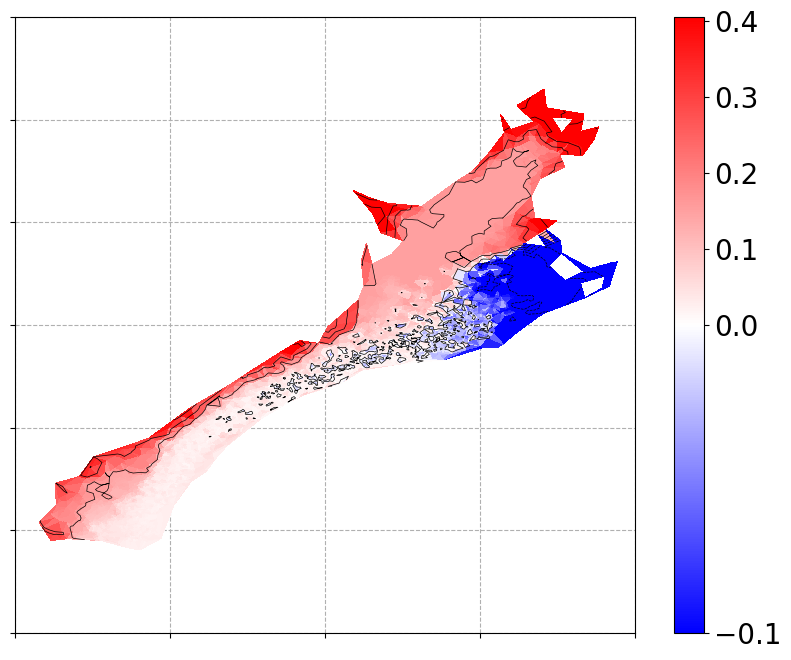

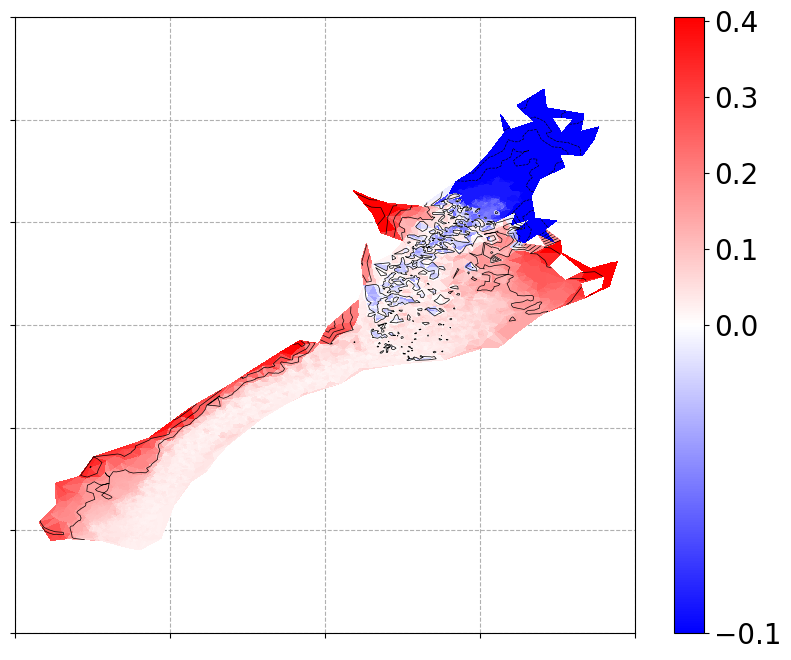

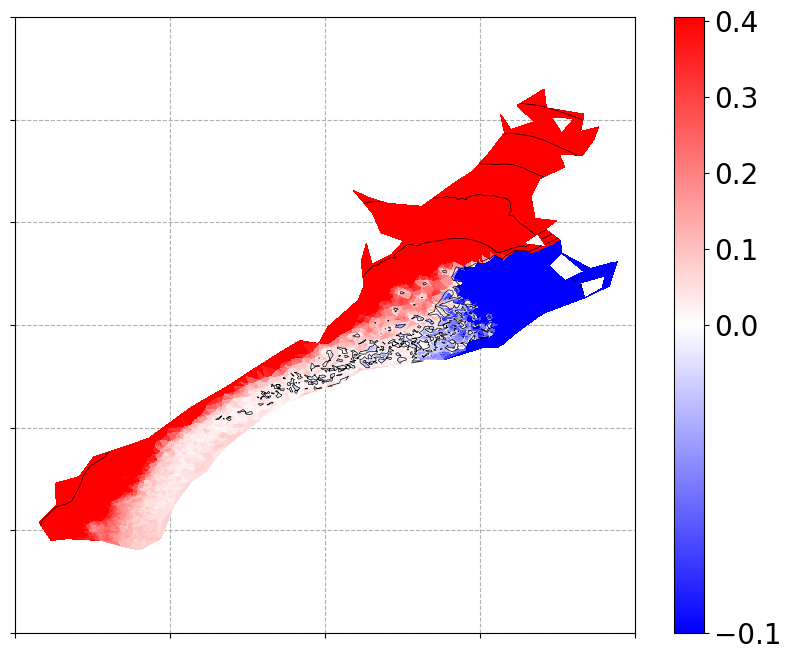

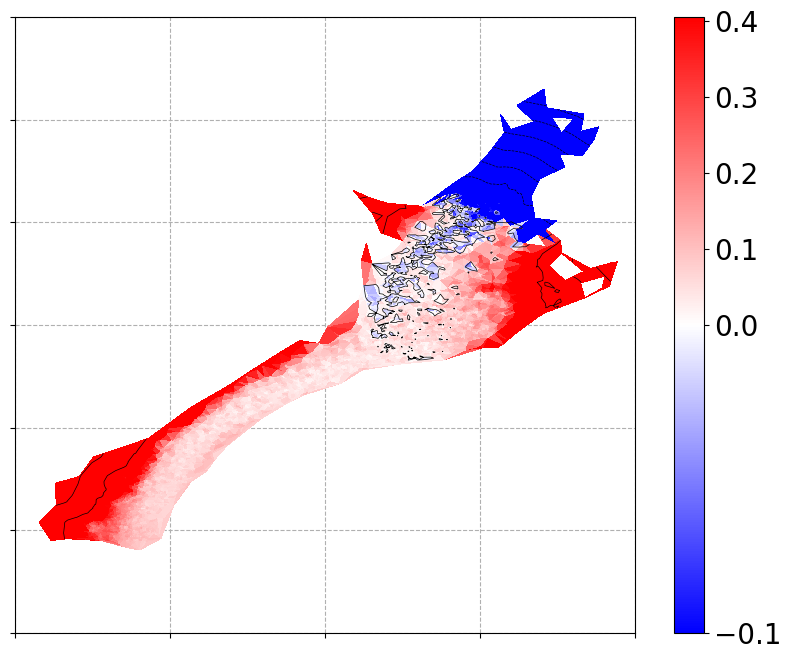

In [51]:
epsbasin.sublevel_set_visualization(adata, eps_key="eps_attracting_basin", 
                           target_cluster_key=good_cluster_key,
                           show_xlabel=False, show_ylabel=False,
                           show_colorbar_label=False, show_xticklabels=False,
                           show_yticklabels=False, vmin=-0.1, vmax=0.405,
                           save_fig=True, save_fig_dir=OUTPUT_DIR,
                           save_fig_name="/Dolphin_eps_attracting_basin_good")
epsbasin.sublevel_set_visualization(adata, eps_key="eps_attracting_basin", 
                           target_cluster_key=bad_cluster_key,
                           show_xlabel=False, show_ylabel=False,
                           show_colorbar_label=False, show_xticklabels=False,
                           show_yticklabels=False, vmin=-0.1, vmax=0.405,
                           save_fig=True, save_fig_dir=OUTPUT_DIR,
                           save_fig_name="/Dolphin_eps_attracting_basin_bad")

epsbasin.sublevel_set_visualization(adata, eps_key="eps_sum_attracting_basin", 
                           target_cluster_key=good_cluster_key,
                           show_xlabel=False, show_ylabel=False,
                           show_colorbar_label=False, show_xticklabels=False,
                           show_yticklabels=False, vmin=-0.1, vmax=0.405,
                           save_fig=True, save_fig_dir=OUTPUT_DIR,
                           save_fig_name="/Dolphin_eps_sum_attracting_basin_good")
epsbasin.sublevel_set_visualization(adata, eps_key="eps_sum_attracting_basin", 
                           target_cluster_key=bad_cluster_key,
                           show_xlabel=False, show_ylabel=False,
                           show_colorbar_label=False, show_xticklabels=False,
                           show_yticklabels=False, vmin=-0.1, vmax=0.405,
                           save_fig=True, save_fig_dir=OUTPUT_DIR,
                           save_fig_name="/Dolphin_eps_sum_attracting_basin_bad")

## Plot debut functions $\underline\varepsilon$ and $\underline\varepsilon_\Sigma$ on the best track

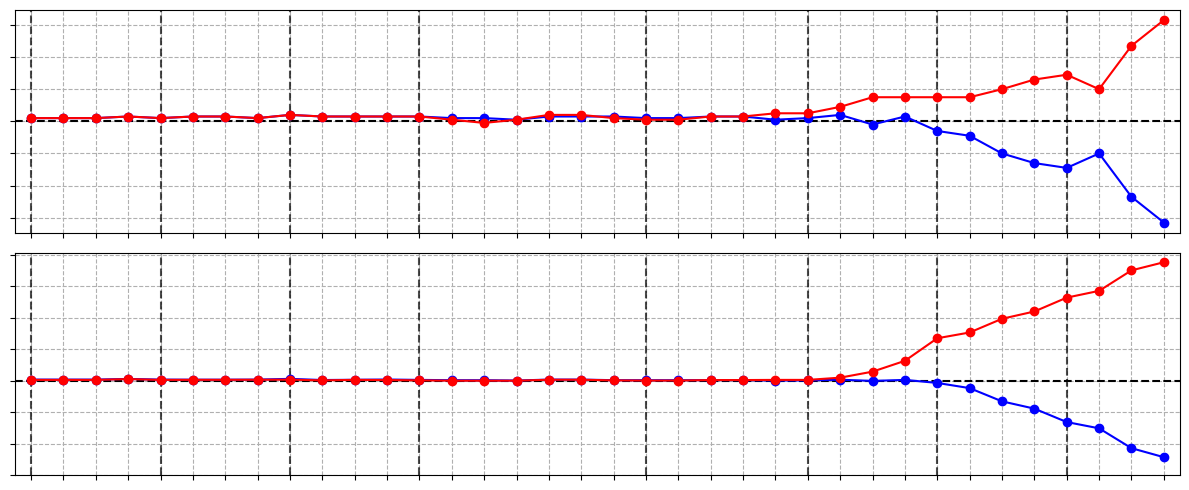

In [52]:
def plot_best_track_eps(
    best_track_df, adata, 
    eps_key="eps_attracting_basin", eps_sum_key="eps_sum_attracting_basin",
    good_cluster_key=None, bad_cluster_key=None, 
    figsize=(12, 7), xticks=True, yticks=True, show_legend=True, output_path=None,
    xticklabels=True, yticklabels=True, ylabel=True
):
    """
    Plot the values of eps and eps_sum for the best track points, for both good and bad clusters.

    Parameters:
        best_track_df (pd.DataFrame): DataFrame containing the best track with columns ['lon', 'lat', 'time'].
        adata (anndata.AnnData): AnnData object containing forecast points and cluster info.
        eps_key (str): Key for epsilon-attracting basin in adata.obs.
        eps_sum_key (str): Key for epsilon-sum-attracting basin in adata.obs.
        good_cluster_key (int or str): Cluster id or name for the good cluster.
        bad_cluster_key (int or str): Cluster id or name for the bad cluster.
        figsize (tuple): Figure size for the plot.
        xticks (bool): Whether to show x-tick labels.
        yticks (bool): Whether to show y-tick labels.
        xticklabels (bool): Whether to show x-tick labels (string).
        yticklabels (bool): Whether to show y-tick labels (string).
        output_path (str): Path to save the output plot.
        show_legend (bool): Whether to show the legend.
    """
    import matplotlib.pyplot as plt

    # Use adata.X as forecast points
    df_points = adata.X

    # Find nearest forecast point for each best track point
    tree = cKDTree(df_points)
    distances, indices = tree.query(best_track_df[['lon', 'lat']].values)

    # Get eps and eps_sum for good/bad clusters
    if good_cluster_key is None or bad_cluster_key is None:
        raise ValueError("good_cluster_key and bad_cluster_key must be specified.")

    best_track_eps_good = adata.obs[f"{eps_key}_{good_cluster_key}"].values[indices]
    best_track_eps_bad = adata.obs[f"{eps_key}_{bad_cluster_key}"].values[indices]
    best_track_eps_sum_good = adata.obs[f"{eps_sum_key}_{good_cluster_key}"].values[indices]
    best_track_eps_sum_bad = adata.obs[f"{eps_sum_key}_{bad_cluster_key}"].values[indices]

    # Format x-axis labels
    plot_x = ["Sep."+str(s)[8:10]+" "+str(s)[11:16] for s in best_track_df['time'].values]

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # eps plot
    axes[0].plot(plot_x, best_track_eps_good, c="r", marker='o', label='Good Cluster', zorder=30)
    axes[0].plot(plot_x, best_track_eps_bad, c="b", marker='o', label='Bad Cluster', zorder=20)
    for i, label in enumerate(plot_x):
        if label.endswith("00:00"):
            axes[0].axvline(x=i, color="k", ls="--", linewidth=1.5, alpha=0.7, zorder=10)
    axes[0].axhline(0, c="k", ls="--", zorder=5)
    axes[0].grid(ls="--", zorder=0)
    if ylabel:
        axes[0].set_ylabel(r"$\varepsilon$", fontsize=14)
    if not yticks:
        axes[0].set_yticks([])
    if not yticklabels:
        axes[0].set_yticklabels([])
    if show_legend:
        axes[0].legend(
            fontsize=12,
            bbox_to_anchor=(1.02, 0.5),
            loc='center left',
            borderaxespad=0.,
            frameon=False,
        )

    # eps_sum plot
    axes[1].plot(plot_x, best_track_eps_sum_good, c="r", marker='o', label='Good Cluster (sum)', linestyle='-', zorder=30)
    axes[1].plot(plot_x, best_track_eps_sum_bad, c="b", marker='o', label='Bad Cluster (sum)', linestyle='-', zorder=20)
    for i, label in enumerate(plot_x):
        if label.endswith("00:00"):
            axes[1].axvline(x=i, color="k", ls="--", linewidth=1.5, alpha=0.7, zorder=10)
    axes[1].axhline(0, c="k", ls="--", zorder=5)
    axes[1].grid(ls="--", zorder=0)
    if ylabel:
        axes[1].set_ylabel(r"$\varepsilon_\Sigma$", fontsize=14)
    if not yticks:
        axes[1].set_yticks([])
    if not yticklabels:
        axes[1].set_yticklabels([])
    if show_legend:
        axes[1].legend(
            fontsize=12,
            bbox_to_anchor=(1.02, 0.5),
            loc='center left',
            borderaxespad=0.,
            frameon=False,
        )
    axes[0].set_yticks(np.arange(-0.6, 0.8, 0.2))  
    axes[1].set_yticks(np.arange(-6, 10, 2))  
    axes[1].set_xticks(range(len(plot_x)))
    if xticklabels:
        axes[1].set_xticklabels(plot_x, rotation=90, fontsize=14)
    else:
        axes[1].set_xticklabels([])
    axes[1].set_xlim(-0.5, len(plot_x) - 0.5)
    axes[0].tick_params(axis='y', labelsize=14)
    axes[1].tick_params(axis='y', labelsize=14)
    if not xticks:
        axes[1].set_xticks([])
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()

output_path = f"{OUTPUT_DIR}/Dolphin_best_track_eps.png"
plot_best_track_eps(best_track_df, adata, good_cluster_key=good_cluster_key, 
                    bad_cluster_key=bad_cluster_key, figsize=(12, 5), 
                    show_legend=False, xticklabels=False, yticklabels=False, ylabel=False,
                    output_path=output_path)